In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
DATA_PATH = Path("Trips_2018.csv")

chunk_iter = pd.read_csv(DATA_PATH, chunksize=500000, low_memory=True,    usecols=lambda c: c != "Unnamed: 0"  # skip useless column
)  # 0.5M rows per chunk

chunks = []
for i, chunk in enumerate(chunk_iter):
    print("Loaded chunk:", i, "→ rows:", len(chunk))
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
print("Combined shape:", df.shape)

Loaded chunk: 0 → rows: 500000
Loaded chunk: 1 → rows: 500000
Loaded chunk: 2 → rows: 500000
Loaded chunk: 3 → rows: 500000
Loaded chunk: 4 → rows: 500000
Loaded chunk: 5 → rows: 500000
Loaded chunk: 6 → rows: 500000
Loaded chunk: 7 → rows: 500000
Loaded chunk: 8 → rows: 500000
Loaded chunk: 9 → rows: 500000
Loaded chunk: 10 → rows: 500000
Loaded chunk: 11 → rows: 500000
Loaded chunk: 12 → rows: 500000
Loaded chunk: 13 → rows: 500000
Loaded chunk: 14 → rows: 500000
Loaded chunk: 15 → rows: 500000
Loaded chunk: 16 → rows: 500000
Loaded chunk: 17 → rows: 500000
Loaded chunk: 18 → rows: 500000
Loaded chunk: 19 → rows: 500000
Loaded chunk: 20 → rows: 500000
Loaded chunk: 21 → rows: 500000
Loaded chunk: 22 → rows: 500000
Loaded chunk: 23 → rows: 500000
Loaded chunk: 24 → rows: 500000
Loaded chunk: 25 → rows: 500000
Loaded chunk: 26 → rows: 500000
Loaded chunk: 27 → rows: 500000
Loaded chunk: 28 → rows: 500000
Loaded chunk: 29 → rows: 500000
Loaded chunk: 30 → rows: 500000
Loaded chunk: 31 →

In [3]:

#Convert start and stop times to proper datetime format
df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
df["stoptime"]  = pd.to_datetime(df.get("stoptime"), errors="coerce")


#Create a new column 'start_hour' — the trip’s start time rounded down to the hour (used later to join with hourly weather data)
df["start_hour"] = df["starttime"].dt.floor("h")

#Compute trip duration in minutes
df["trip_duration_min"] = (
    df["tripduration"]/60.0
    if "tripduration" in df.columns
    else (df["stoptime"] - df["starttime"]).dt.total_seconds()/60
)

#Find a representative latitude and longitude for weather data Using median coordinates ensures one central location (e.g., NYC center)
LAT, LON = df["start_station_latitude"].median(), df["start_station_longitude"].median()

#Find the overall date range of the dataset for API query
START = df["start_hour"].min().date().isoformat()
END   = df["start_hour"].max().date().isoformat()

#Print a quick summary
print(f"Trips: {len(df)}  |  Date span: {START} → {END}")
df.head()

Trips: 17548339  |  Date span: 2018-01-01 → 2018-12-31


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0           505.0             40.749013             -73.988484   31956   
1          3255.0             40.750585             -73.994685   32536   
2           525.0             40.755942             -74.002116   16069   
3           447.0             40.763707             -73.985162   31781   
4          3356.0             40.774667             -73.984706   30319   

     usertype  birth_year  gender          start_hour  trip_duration_min  
0  Subscriber        1992       1 2018-01-01 13:00:00          16.166667  
1  Subscriber        1969       1 2018-01-01 15:00:00          12.050000  
2  Subscriber        1956       1 2018-01-01 15:00:00           8.266667  
3  Subscriber        1974       1 2018-01-01 15:00:00           5.100000  
4  Subscriber        1992       1 2018-01-01 18:00:00           5.100000

In [4]:
stations = df[["start_station_id", "start_station_latitude", "start_station_longitude"]].drop_duplicates()

# 1) Build a small grid (≈2–3 km) to reduce API calls
GRID = 0.03  # ↑ 0.05 fewer calls, ↓ 0.02 more detail

stations = stations.copy()
stations["lat_bin"] = (stations["start_station_latitude"]  / GRID).round().astype(int)
stations["lon_bin"] = (stations["start_station_longitude"] / GRID).round().astype(int)
stations["cell_id"] = stations["lat_bin"].astype(str) + "_" + stations["lon_bin"].astype(str)

cells = (stations.groupby("cell_id", as_index=False)
         .agg(lat=("start_station_latitude", "median"),
              lon=("start_station_longitude", "median")))

print(f"Unique grid cells to fetch: {len(cells)}")


# 2) Helper: polite, retrying fetch per cell
def fetch_cell(lat, lon, start_date, end_date, retries=5, pause=1.5):
    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = [
        "temperature_2m","apparent_temperature","rain","snowfall",
        "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
    ]
    params = {
        "latitude": float(lat), "longitude": float(lon),
        "start_date": start_date, "end_date": end_date,
        "timezone": "America/New_York",
        "hourly": ",".join(hourly_vars)  # more robust than list for some clients
    }
    last_err = None
    for a in range(retries):
        try:
            resp = requests.get(url, params=params, timeout=40)
            if resp.ok:
                js = resp.json()
                if "hourly" in js:
                    wx = pd.DataFrame(js["hourly"])
                    wx["start_hour"] = pd.to_datetime(wx["time"])
                    wx = wx.drop(columns=["time"])
                    # downcast floats to save memory
                    for c in wx.columns:
                        if c != "start_hour" and pd.api.types.is_float_dtype(wx[c]):
                            wx[c] = pd.to_numeric(wx[c], downcast="float")
                    return wx
                else:
                    last_err = f"no 'hourly' in response (keys={list(js.keys())})"
            else:
                last_err = f"HTTP {resp.status_code}: {resp.text[:160]}"
        except Exception as e:
            last_err = str(e)
        time.sleep(pause * (a + 1))  # gentle backoff
    # Uncomment for debugging:
    # print(f"Fetch failed for ({lat:.4f},{lon:.4f}): {last_err}")
    return None


# 3) Fetch once per cell
cell_weather, failed_cells = [], []
for _, r in cells.iterrows():
    wx_cell = fetch_cell(r["lat"], r["lon"], START, END)
    if wx_cell is None:
        failed_cells.append(r["cell_id"])
        continue
    wx_cell["cell_id"] = r["cell_id"]
    cell_weather.append(wx_cell)
    time.sleep(0.2)  # pacing

# --- Fallback if everything failed: use single (city-median) point ---
if not cell_weather:
    print(" All grid cells failed. Falling back to city-median weather…")
    lat0 = float(df["start_station_latitude"].median())
    lon0 = float(df["start_station_longitude"].median())
    wx_city = fetch_cell(lat0, lon0, START, END)
    if wx_city is None:
        raise RuntimeError(
            f"No weather fetched even for city median. Check network/date range. START={START}, END={END}"
        )
    wx_city["cell_id"] = "city_median"
    wx_cells = wx_city.copy()
    stations2 = stations.copy()
    stations2["use_cell"] = "city_median"
else:
    wx_cells = pd.concat(cell_weather, ignore_index=True)
    print(f"Weather rows (cells): {len(wx_cells)} | cells covered: {wx_cells['cell_id'].nunique()}")

    # 4) If some cells failed, borrow weather from nearest fetched cell
    if failed_cells:
        print("Filling missing cells from nearest fetched cell…")

        have = cells[cells["cell_id"].isin(wx_cells["cell_id"].unique())].copy()
        need = cells[cells["cell_id"].isin(failed_cells)].copy()

        def haversine(lat1, lon1, lat2, lon2):
            R = 6371.0
            lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return 2 * R * np.arcsin(np.sqrt(a))

        alias_rows = []
        H_lat = have["lat"].to_numpy()
        H_lon = have["lon"].to_numpy()
        for _, r in need.iterrows():
            d = haversine(r["lat"], r["lon"], H_lat, H_lon)
            nearest = have.iloc[d.argmin()]["cell_id"]
            alias_rows.append((r["cell_id"], nearest))
        alias = pd.DataFrame(alias_rows, columns=["cell_id", "use_cell"])
    else:
        alias = pd.DataFrame(columns=["cell_id", "use_cell"])

    # Stations use their own cell if fetched, otherwise the nearest fetched cell
    stations2 = stations.merge(alias, on="cell_id", how="left")
    stations2["use_cell"] = stations2["use_cell"].fillna(stations2["cell_id"])

# 5) Expand cell weather back to stations
wx = (stations2[["start_station_id", "use_cell"]]
      .rename(columns={"use_cell": "cell_id"})
      .merge(wx_cells, on="cell_id", how="left"))

print("Total weather rows (expanded to stations):", len(wx))

Unique grid cells to fetch: 26
Weather rows (cells): 227760 | cells covered: 26
Total weather rows (expanded to stations): 8050440


In [5]:
#Hourly city-level weather from wx_cells
# dfm too large so i decided to not use it 

weather_hourly = (
    wx_cells
    .groupby("start_hour")[[
        "temperature_2m",
        "rain",
        "snowfall",
        "wind_speed_10m",
        "cloud_cover",
        "visibility"
    ]]
    .mean()
    .reset_index()
    .rename(columns={"start_hour": "hour"})
)

print("Weather_hourly shape:", weather_hourly.shape)
print(weather_hourly.head())


Weather_hourly shape: (8760, 7)
                 hour  temperature_2m  rain  snowfall  wind_speed_10m  \
0 2018-01-01 00:00:00      -13.665384   0.0       0.0       16.234615   
1 2018-01-01 01:00:00      -13.823076   0.0       0.0       16.299999   
2 2018-01-01 02:00:00      -14.042308   0.0       0.0       15.699999   
3 2018-01-01 03:00:00      -14.261538   0.0       0.0       15.211538   
4 2018-01-01 04:00:00      -14.446154   0.0       0.0       15.830770   

   cloud_cover visibility  
0     0.115385        NaN  
1     1.192308        NaN  
2     1.807692        NaN  
3     2.115385        NaN  
4     2.153846        NaN  


In [6]:
# --- Feature engineering ON WEATHER_ONLY (weather_hourly) ---

# 1) Temperature (°C)
weather_hourly["temp_celsius"] = weather_hourly["temperature_2m"]

# 2) Dryness flag
rain  = weather_hourly["rain"].fillna(0)
snow  = weather_hourly["snowfall"].fillna(0)
weather_hourly["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind
weather_hourly["wind_kmh"] = weather_hourly["wind_speed_10m"] * 3.6

# 4) Visibility (only if column exists)
if "visibility" in weather_hourly.columns:
    weather_hourly["visibility_km"] = weather_hourly["visibility"] / 1000.0
else:
    # Create a dummy value (or NaN) if visibility missing
    weather_hourly["visibility_km"] = np.nan

# 5) Cycling score
weather_hourly["cycling_score"] = (
    np.exp(-((weather_hourly["temp_celsius"] - 20) / 10) ** 2) * 40
    + weather_hourly["is_dry"] * 30
    + (weather_hourly["wind_kmh"] < 20).astype("int8") * 20
    + (weather_hourly["visibility_km"] > 5).astype("int8") * 10
).clip(0, 100)

weather_hourly.head()


hour  temperature_2m  rain  snowfall  wind_speed_10m  \
0 2018-01-01 00:00:00      -13.665384   0.0       0.0       16.234615   
1 2018-01-01 01:00:00      -13.823076   0.0       0.0       16.299999   
2 2018-01-01 02:00:00      -14.042308   0.0       0.0       15.699999   
3 2018-01-01 03:00:00      -14.261538   0.0       0.0       15.211538   
4 2018-01-01 04:00:00      -14.446154   0.0       0.0       15.830770   

   cloud_cover visibility  temp_celsius  is_dry   wind_kmh visibility_km  \
0     0.115385        NaN    -13.665384       1  58.444614           NaN   
1     1.192308        NaN    -13.823076       1  58.679996           NaN   
2     1.807692        NaN    -14.042308       1  56.519993           NaN   
3     2.115385        NaN    -14.261538       1  54.761536           NaN   
4     2.153846        NaN    -14.446154       1  56.990768           NaN   

   cycling_score  
0      30.000479  
1      30.000431  
2      30.000370  
3      30.000319  
4      30.000280

In [7]:

'''
is_station_level = "start_station_id" in wx.columns

if is_station_level:
    df["start_station_id"] = pd.array(df["start_station_id"], dtype="Int32")
    wx["start_station_id"] = pd.array(wx["start_station_id"], dtype="Int32")

key_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])

print("Merging on:", key_cols)

# keep only weather fields we actually need (saves memory) if present
wanted_wx = [
    "start_hour", "start_station_id",
    "temperature_2m","apparent_temperature","rain","snowfall",
    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
]

wx_subset = wx.filter(items=[c for c in wanted_wx if c in wx.columns], axis=1)
if is_station_level and "start_station_id" in wx_subset.columns:
    wx_subset["start_station_id"] = pd.array(wx_subset["start_station_id"], dtype="Int32")

wx_keyed = wx_subset.drop_duplicates(subset=key_cols)

dfm = df.merge(
    wx_keyed,
    on=key_cols,
    how="left",          # keep all trips/columns from df
    validate="m:1",      # many trips to one weather row
    copy=False
)

# merge quality
total_rows = len(dfm)
valid_weather = dfm["temperature_2m"].count()
coverage_pct = (valid_weather / total_rows * 100) if total_rows else 0.0
print(f"Merge complete | rows={total_rows:,} | weather coverage={coverage_pct:.1f}%")

dfm.head()'''

'\nis_station_level = "start_station_id" in wx.columns\n\nif is_station_level:\n    df["start_station_id"] = pd.array(df["start_station_id"], dtype="Int32")\n    wx["start_station_id"] = pd.array(wx["start_station_id"], dtype="Int32")\n\nkey_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])\n\nprint("Merging on:", key_cols)\n\n# keep only weather fields we actually need (saves memory) if present\nwanted_wx = [\n    "start_hour", "start_station_id",\n    "temperature_2m","apparent_temperature","rain","snowfall",\n    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"\n]\n\nwx_subset = wx.filter(items=[c for c in wanted_wx if c in wx.columns], axis=1)\nif is_station_level and "start_station_id" in wx_subset.columns:\n    wx_subset["start_station_id"] = pd.array(wx_subset["start_station_id"], dtype="Int32")\n\nwx_keyed = wx_subset.drop_duplicates(subset=key_cols)\n\ndfm = df.merge(\n    wx_keyed,\n    on=key_cols,\n    how="left",          # keep a

In [8]:
'''#Feature engineering: concise, robust, memory-friendly ===

need = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]
for c in need:
    if c not in dfm.columns:
        dfm[c] = np.nan
dfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")

# 1) Temperature (°C) + readable buckets
dfm["temp_celsius"] = dfm["temperature_2m"]
dfm["temp_category"] = pd.cut(
    dfm["temp_celsius"],
    bins=[-99, 0, 10, 20, 25, 30, 99],
    labels=["freezing","cold","cool","comfortable","warm","hot"]
)

# 2) Dryness (1 dry, 0 wet)
rain  = dfm["rain"].fillna(0)
snow  = dfm["snowfall"].fillna(0)
dfm["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind, sky, visibility
dfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6
dfm["sky_condition"] = pd.cut(
    dfm["cloud_cover"],
    bins=[-1, 25, 50, 75, 100.1],
    labels=["clear","partly_cloudy","cloudy","overcast"]
)
dfm["visibility_km"] = dfm["visibility"] / 1000.0

# 4) Cycling Score (0–100): temp comfort 40% + dryness 30% + low wind 20% + visibility 10%
dfm["cycling_score"] = (
    np.exp(-((dfm["temp_celsius"] - 20) / 10) ** 2) * 40           # temperature comfort peak ~20°C
    + dfm["is_dry"] * 30                                           # dry bonus
    + (dfm["wind_kmh"] < 20).astype("int8") * 20                   # calm wind
    + (dfm["visibility_km"] > 5).astype("int8") * 10               # clear view
).clip(0, 100)

# 5) Compact memory for categories
dfm["temp_category"] = dfm["temp_category"].astype("category")
dfm["sky_condition"]  = dfm["sky_condition"].astype("category")

print(f"Weather features added | shape={dfm.shape} | new cols: "
      f"['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']")
dfm.head()'''

'#Feature engineering: concise, robust, memory-friendly ===\n\nneed = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]\nfor c in need:\n    if c not in dfm.columns:\n        dfm[c] = np.nan\ndfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")\n\n# 1) Temperature (°C) + readable buckets\ndfm["temp_celsius"] = dfm["temperature_2m"]\ndfm["temp_category"] = pd.cut(\n    dfm["temp_celsius"],\n    bins=[-99, 0, 10, 20, 25, 30, 99],\n    labels=["freezing","cold","cool","comfortable","warm","hot"]\n)\n\n# 2) Dryness (1 dry, 0 wet)\nrain  = dfm["rain"].fillna(0)\nsnow  = dfm["snowfall"].fillna(0)\ndfm["is_dry"] = ((rain + snow) == 0).astype("int8")\n\n# 3) Wind, sky, visibility\ndfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6\ndfm["sky_condition"] = pd.cut(\n    dfm["cloud_cover"],\n    bins=[-1, 25, 50, 75, 100.1],\n    labels=["clear","partly_cloudy","cloudy","overcast"]\n)\ndfm["visibility_km"] = dfm["visibility"] / 1000.0\n\n# 4) Cycling Score (0–100):

In [9]:
'''# Add temporal columns needed for analysis
dfm['day_of_week'] = dfm['starttime'].dt.dayofweek
dfm['is_weekend'] = (dfm['day_of_week'] >= 5).astype(int)
dfm['hour'] = dfm['start_hour'].dt.hour
dfm['month'] = dfm['starttime'].dt.month

print(f"Dataset ready: {len(dfm):,} trips with weather and temporal features")'''

'# Add temporal columns needed for analysis\ndfm[\'day_of_week\'] = dfm[\'starttime\'].dt.dayofweek\ndfm[\'is_weekend\'] = (dfm[\'day_of_week\'] >= 5).astype(int)\ndfm[\'hour\'] = dfm[\'start_hour\'].dt.hour\ndfm[\'month\'] = dfm[\'starttime\'].dt.month\n\nprint(f"Dataset ready: {len(dfm):,} trips with weather and temporal features")'

In [10]:
hourly_demand = (
    df.groupby("start_hour", observed=True)
      .size()
      .rename("trip_count")
      .reset_index()
      .sort_values("start_hour")
      .reset_index(drop=True)
)

hourly_demand.head()

start_hour  trip_count
0 2018-01-01 00:00:00         119
1 2018-01-01 01:00:00         168
2 2018-01-01 02:00:00          98
3 2018-01-01 03:00:00          72
4 2018-01-01 04:00:00          34

In [11]:
import pandas as pd

# 1. Make sure start_hour is datetime
df = df.copy()
df["start_hour"] = pd.to_datetime(df["start_hour"])

# 2. Compute pickups per (station, hour) 
pickups = (
    df.groupby(["start_station_id", "start_hour"])
      .size()
      .reset_index(name="pickups")
      .rename(columns={"start_station_id": "station_id", "start_hour": "hour"})
)

# 3. Compute dropoffs per (station, hour) 
dropoffs = (
    df.groupby(["end_station_id", "start_hour"])
      .size()
      .reset_index(name="dropoffs")
      .rename(columns={"end_station_id": "station_id", "start_hour": "hour"})
)

#  4. Ensure merge keys have the SAME dtype 
# Option A: use integers (recommended if IDs are numeric)
pickups["station_id"] = pickups["station_id"].astype("int64")
dropoffs["station_id"] = dropoffs["station_id"].astype("int64")

pickups["hour"] = pd.to_datetime(pickups["hour"])
dropoffs["hour"] = pd.to_datetime(dropoffs["hour"])

# 5. Merge pickups and dropoffs on (station_id, hour) 
hourly_demand1 = (
    pd.merge(pickups, dropoffs, on=["station_id", "hour"], how="outer")
      .fillna(0)
)

# Cast counts to normal ints
hourly_demand1["pickups"] = hourly_demand1["pickups"].astype("int32")
hourly_demand1["dropoffs"] = hourly_demand1["dropoffs"].astype("int32")

# 6. Build full grid: all stations x all hours 
min_hour = hourly_demand1["hour"].min()
max_hour = hourly_demand1["hour"].max()
all_hours = pd.date_range(min_hour, max_hour, freq="H")

stations = hourly_demand1["station_id"].unique()
index = pd.MultiIndex.from_product([stations, all_hours], names=["station_id", "hour"])

hourly_demand1 = (
    hourly_demand1
      .set_index(["station_id", "hour"])
      .reindex(index, fill_value=0)
      .reset_index()
)

hourly_demand1.head(90)


C:\Users\mikke\AppData\Local\Temp\ipykernel_9784\1183037343.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(min_hour, max_hour, freq="H")


station_id                hour  pickups  dropoffs
0           72 2018-01-01 00:00:00        0         0
1           72 2018-01-01 01:00:00        0         0
2           72 2018-01-01 02:00:00        0         0
3           72 2018-01-01 03:00:00        0         0
4           72 2018-01-01 04:00:00        0         0
..         ...                 ...      ...       ...
85          72 2018-01-04 13:00:00        0         0
86          72 2018-01-04 14:00:00        0         0
87          72 2018-01-04 15:00:00        1         0
88          72 2018-01-04 16:00:00        0         0
89          72 2018-01-04 17:00:00        0         0

[90 rows x 4 columns]

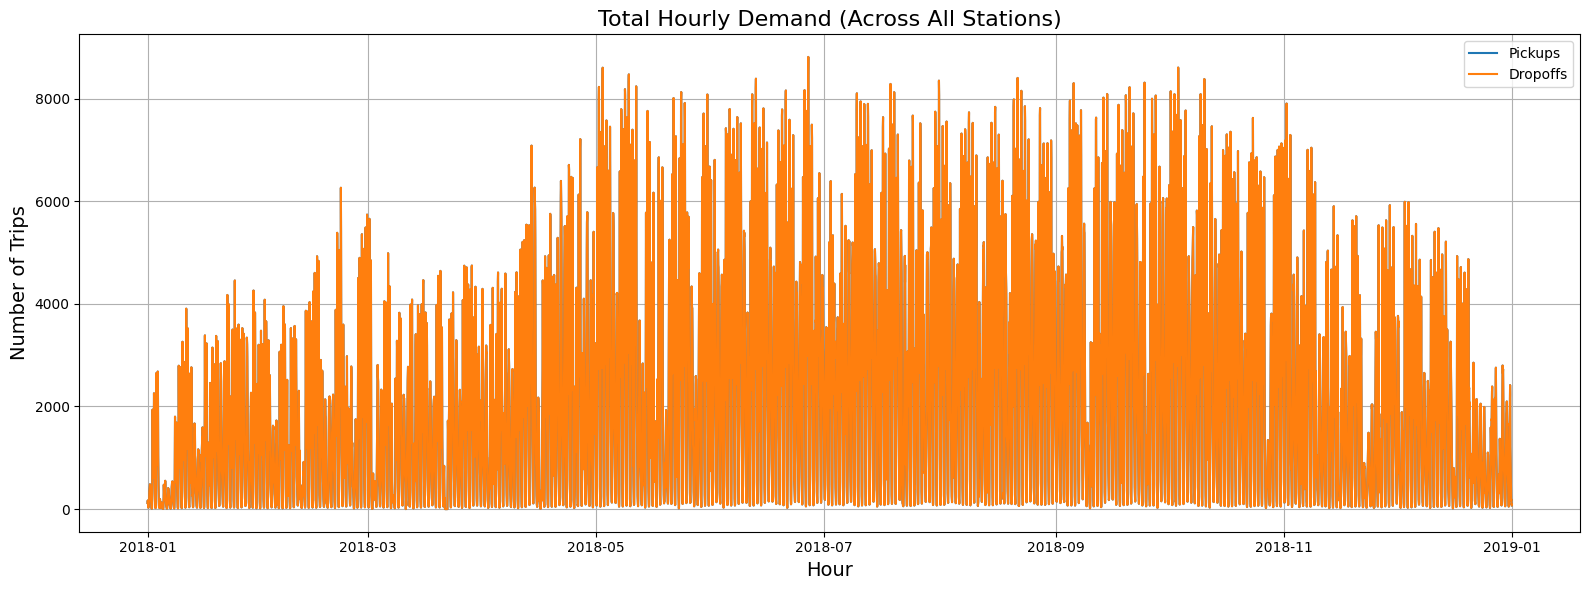

In [12]:
total_hourly = hourly_demand1.groupby("hour")[["pickups", "dropoffs"]].sum()

plt.figure(figsize=(16,6))
plt.plot(total_hourly.index, total_hourly["pickups"], label="Pickups")
plt.plot(total_hourly.index, total_hourly["dropoffs"], label="Dropoffs")

plt.title("Total Hourly Demand (Across All Stations)", fontsize=16)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


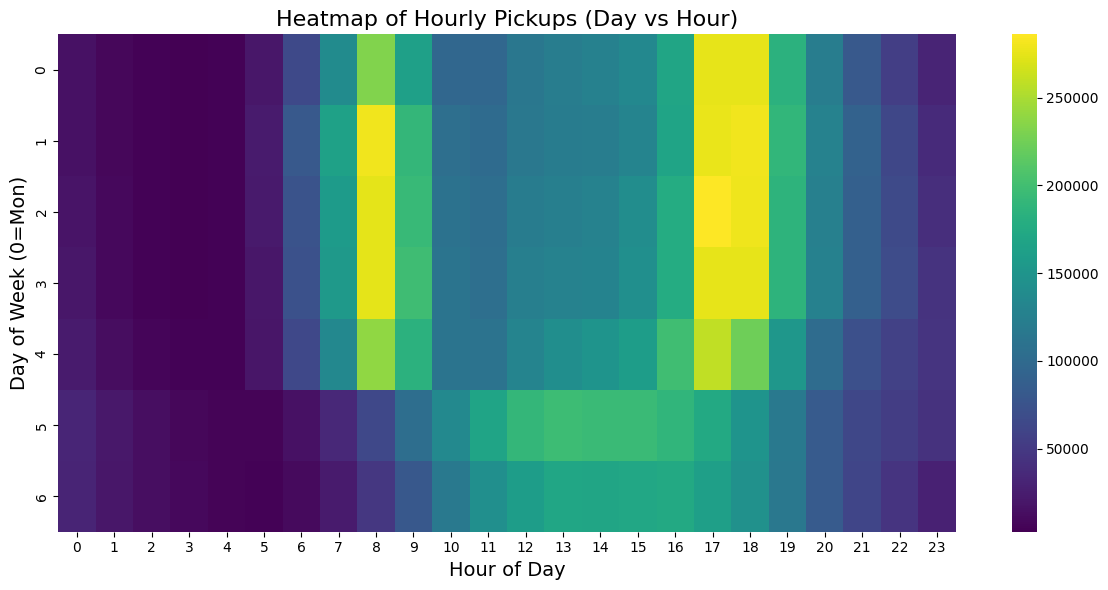

In [13]:
# Create hour-of-day & day-of-week fields
hourly_demand1['hour_of_day'] = hourly_demand1['hour'].dt.hour
hourly_demand1['day_of_week'] = hourly_demand1['hour'].dt.dayofweek  # 0=Monday

# Aggregate pickups by hour & day of week
heatmap_df = hourly_demand1.groupby(["day_of_week", "hour_of_day"])["pickups"].sum().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_df, cmap="viridis")

plt.title("Heatmap of Hourly Pickups (Day vs Hour)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Day of Week (0=Mon)", fontsize=14)
plt.tight_layout()
plt.show()


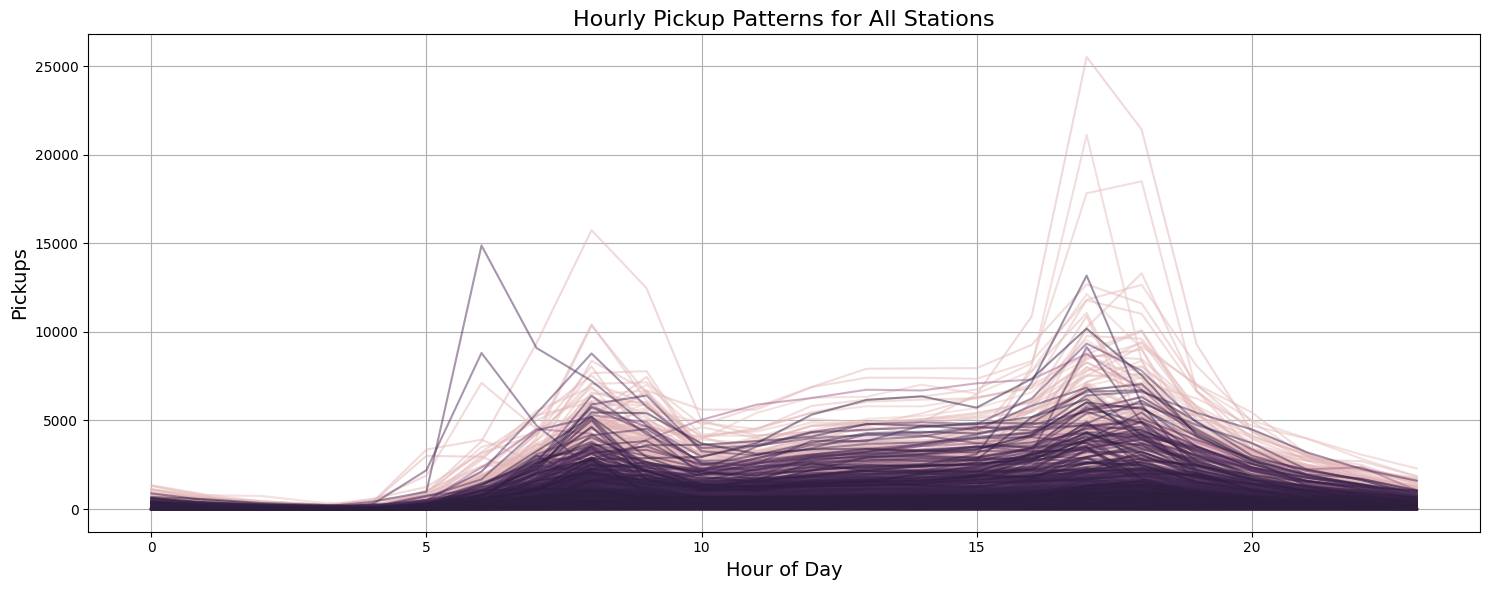

In [14]:
# Average hourly demand per station
station_hour = hourly_demand1.groupby(["station_id", "hour_of_day"])["pickups"].sum().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=station_hour, x="hour_of_day", y="pickups", hue="station_id", legend=False, alpha=0.5)

plt.title("Hourly Pickup Patterns for All Stations", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Pickups", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


Number of unique stations: 850


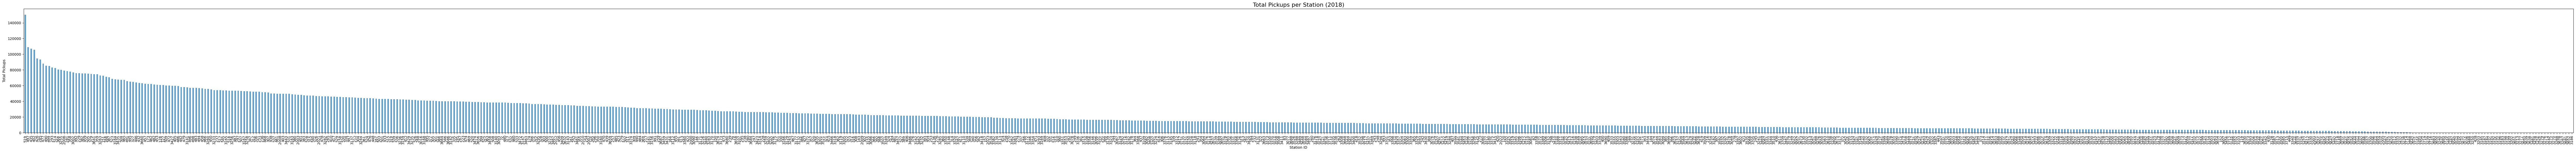

In [15]:
unique_stations = hourly_demand1['station_id'].nunique()
print(f"Number of unique stations: {unique_stations}")

station_totals = (
    hourly_demand1.groupby("station_id")["pickups"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(100,6))
station_totals.plot(kind='bar', alpha=0.7)

plt.title("Total Pickups per Station (2018)", fontsize=16)
plt.xlabel("Station ID")
plt.ylabel("Total Pickups")
plt.tight_layout()
plt.show()


# Clustering

In [16]:
start_meta = df.groupby("start_station_id")[
    ["start_station_latitude", "start_station_longitude"]
].mean().reset_index().rename(columns={
    "start_station_id": "station_id",
    "start_station_latitude": "lat",
    "start_station_longitude": "lon"
})

end_meta = df.groupby("end_station_id")[
    ["end_station_latitude", "end_station_longitude"]
].mean().reset_index().rename(columns={
    "end_station_id": "station_id",
    "end_station_latitude": "lat",
    "end_station_longitude": "lon"
})

# Combine both tables
stations_meta = pd.concat([start_meta, end_meta], ignore_index=True)

# If the same station appears in both start & end tables, take average again
stations_meta = stations_meta.groupby("station_id")[["lat", "lon"]].mean().reset_index()

print("Number of unique stations:", len(stations_meta))
stations_meta.head()

Number of unique stations: 850


station_id        lat        lon
0        72.0  40.767272 -73.993929
1        79.0  40.719116 -74.006667
2        82.0  40.711174 -74.000165
3        83.0  40.683826 -73.976323
4       119.0  40.696089 -73.978034

In [17]:
stations_meta = stations_meta[
    (stations_meta['lat'] > 40.4) &
    (stations_meta['lat'] < 41) &
    (stations_meta['lon'] > -74.1) &
    (stations_meta['lon'] < -73.7)
]

N_CLUSTERS = 25   # you can choose any number >= 20

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init='auto'
)

stations_meta["cluster"] = kmeans.fit_predict(stations_meta[["lat", "lon"]])

stations_meta.head()

station_id        lat        lon  cluster
0        72.0  40.767272 -73.993929        1
1        79.0  40.719116 -74.006667       22
2        82.0  40.711174 -74.000165       14
3        83.0  40.683826 -73.976323       20
4       119.0  40.696089 -73.978034       20

In [18]:
# Merge clusters back into hourly_demand
hourly_demand1 = hourly_demand1.merge(
    stations_meta[["station_id", "cluster"]],
    on="station_id",
    how="left"
)
hourly_demand1

station_id                hour  pickups  dropoffs  hour_of_day  \
0                72 2018-01-01 00:00:00        0         0            0   
1                72 2018-01-01 01:00:00        0         0            1   
2                72 2018-01-01 02:00:00        0         0            2   
3                72 2018-01-01 03:00:00        0         0            3   
4                72 2018-01-01 04:00:00        0         0            4   
...             ...                 ...      ...       ...          ...   
7445995        3721 2018-12-31 19:00:00        0         0           19   
7445996        3721 2018-12-31 20:00:00        0         0           20   
7445997        3721 2018-12-31 21:00:00        0         0           21   
7445998        3721 2018-12-31 22:00:00        0         0           22   
7445999        3721 2018-12-31 23:00:00        0         0           23   

         day_of_week  cluster  
0                  0      1.0  
1                  0      1.0  
2                  0      1.0  
3                  0      1.0  
4                  0      1.0  
...              ...      ...  
7445995            0      7.0  
7445996            0      7.0  
7445997            0      7.0  
7445998            0      7.0  
7445999            0      7.0  

[7446000 rows x 7 columns]

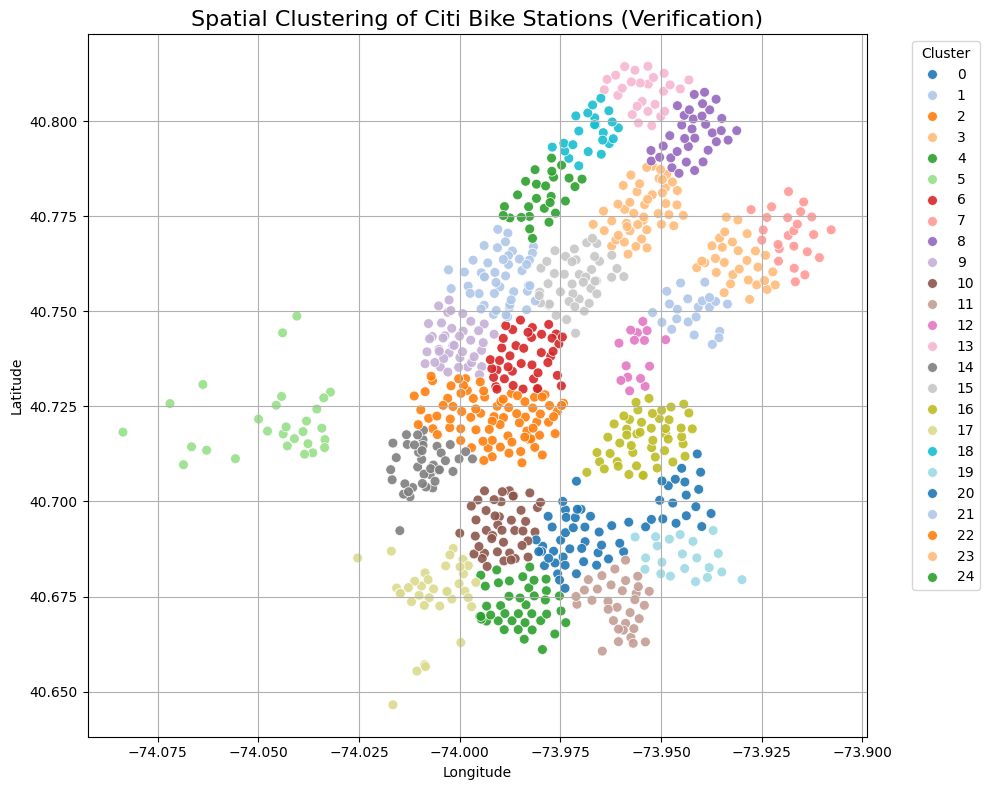

In [19]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=50,
    alpha=0.9
)

plt.title("Spatial Clustering of Citi Bike Stations (Verification)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

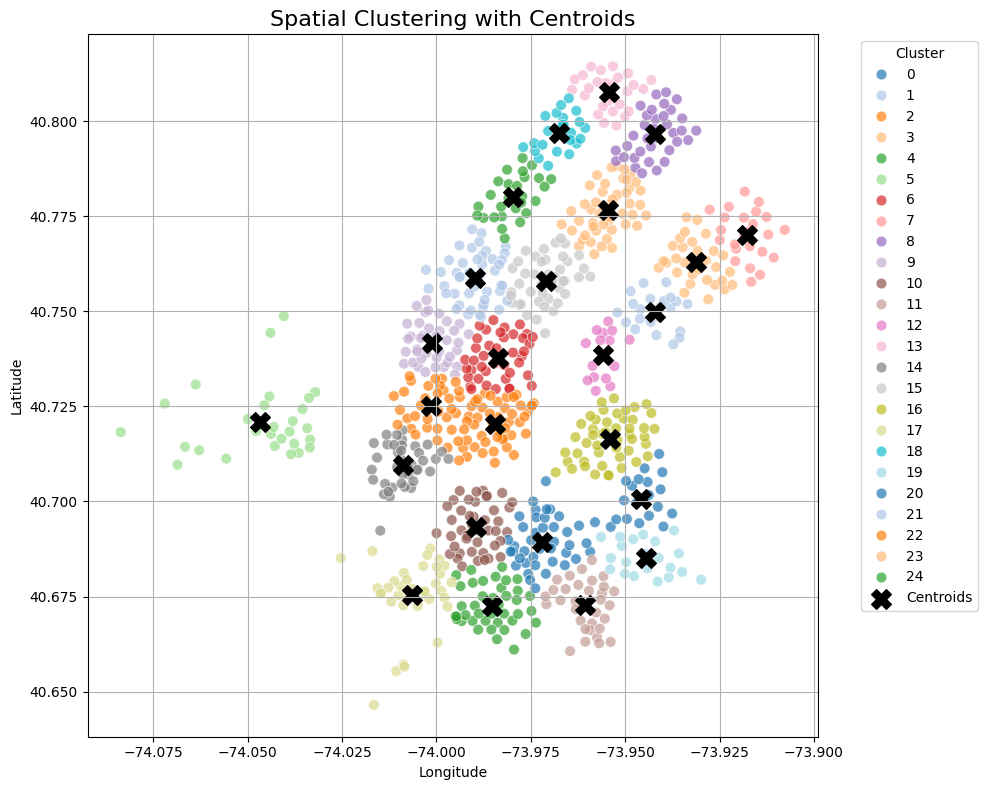

In [20]:
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))

# Plot stations
sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=60,
    alpha=0.7
)

# Plot centroids
plt.scatter(
    centroids[:,1],  # lon
    centroids[:,0],  # lat
    s=200,
    c="black",
    marker="X",
    label="Centroids"
)

plt.title("Spatial Clustering with Centroids", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Merge cluster labels to hourly demand
hourly_cluster_demand = hourly_demand1.merge(
    stations_meta[['station_id', 'cluster']],
    on='station_id',
    how='left'
)

hourly_cluster_demand = hourly_cluster_demand.drop(columns=["cluster_y"])
hourly_cluster_demand = hourly_cluster_demand.rename(columns={"cluster_x": "cluster"})
hourly_cluster_demand = hourly_cluster_demand.sort_values(["cluster", "hour"])
hourly_cluster_demand = hourly_cluster_demand.set_index("hour")

hourly_cluster_demand.head()


station_id  pickups  dropoffs  hour_of_day  day_of_week  cluster
hour                                                                        
2018-01-01         372        0         0            0            0      0.0
2018-01-01         373        0         1            0            0      0.0
2018-01-01        3059        0         0            0            0      0.0
2018-01-01        3060        0         0            0            0      0.0
2018-01-01        3061        0         0            0            0      0.0

In [22]:
cluster_ts = (
    hourly_cluster_demand
    .groupby("cluster")
    .resample("h")
    .sum()[["pickups", "dropoffs"]]
    .reset_index()
)
cluster_ts.head()


cluster                hour  pickups  dropoffs
0      0.0 2018-01-01 00:00:00        1         2
1      0.0 2018-01-01 01:00:00        0         0
2      0.0 2018-01-01 02:00:00        0         0
3      0.0 2018-01-01 03:00:00        3         3
4      0.0 2018-01-01 04:00:00        0         0

In [23]:
cluster_ts["hour_of_day"] = cluster_ts["hour"].dt.hour
cluster_ts["day_of_week"] = cluster_ts["hour"].dt.weekday
cluster_ts["month"] = cluster_ts["hour"].dt.month
cluster_ts["day"] = cluster_ts["hour"].dt.day
cluster_ts.head()

cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0      0.0 2018-01-01 00:00:00        1         2            0            0   
1      0.0 2018-01-01 01:00:00        0         0            1            0   
2      0.0 2018-01-01 02:00:00        0         0            2            0   
3      0.0 2018-01-01 03:00:00        3         3            3            0   
4      0.0 2018-01-01 04:00:00        0         0            4            0   

   month  day  
0      1    1  
1      1    1  
2      1    1  
3      1    1  
4      1    1

In [24]:
train = cluster_ts[cluster_ts["month"] <= 10].reset_index(drop=True)

# VALIDATION: November
val = cluster_ts[(cluster_ts["month"] == 11)].reset_index(drop=True)

# TEST: December
test = cluster_ts[(cluster_ts["month"] == 12)].reset_index(drop=True)

print("Train rows:", len(train))
print("Validation rows:", len(val))
print("Test rows:", len(test))

Train rows: 182400
Validation rows: 18000
Test rows: 18600


Baseline Model for Pickups

In [25]:
baseline = (
    train.groupby(["cluster", "hour_of_day"])
    .agg({
        "pickups": "mean",
        "dropoffs": "mean"
    })
    .reset_index()
    .rename(columns={
        "pickups": "baseline_pickups",
        "dropoffs": "baseline_dropoffs"
    })
)

baseline.head()


cluster  hour_of_day  baseline_pickups  baseline_dropoffs
0      0.0            0          5.888158           8.644737
1      0.0            1          3.516447           4.582237
2      0.0            2          2.338816           2.786184
3      0.0            3          1.638158           1.746711
4      0.0            4          1.447368           1.582237

In [26]:
val_pred = val.merge(
    baseline,
    on=["cluster", "hour_of_day"],
    how="left"
)

# Fill missing predictions with global mean if needed
val_pred["baseline_pickups"].fillna(train["pickups"].mean(), inplace=True)
val_pred["baseline_dropoffs"].fillna(train["dropoffs"].mean(), inplace=True)

val_pred.head(20)

C:\Users\mikke\AppData\Local\Temp\ipykernel_9784\4173580317.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  val_pred["baseline_pickups"].fillna(train["pickups"].mean(), inplace=True)
C:\Users\mikke\AppData\Local\Temp\ipykernel_9784\4173580317.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0       0.0 2018-11-01 00:00:00       12        13            0            3   
1       0.0 2018-11-01 01:00:00        8        14            1            3   
2       0.0 2018-11-01 02:00:00        2         8            2            3   
3       0.0 2018-11-01 03:00:00        4         6            3            3   
4       0.0 2018-11-01 04:00:00        3         4            4            3   
5       0.0 2018-11-01 05:00:00        4         1            5            3   
6       0.0 2018-11-01 06:00:00       13        12            6            3   
7       0.0 2018-11-01 07:00:00       24        18            7            3   
8       0.0 2018-11-01 08:00:00       56        42            8            3   
9       0.0 2018-11-01 09:00:00       49        30            9            3   
10      0.0 2018-11-01 10:00:00       22        13           10            3   
11      0.0 2018-11-01 11:00:00       18        13           11            3   
12      0.0 2018-11-01 12:00:00       26        18           12            3   
13      0.0 2018-11-01 13:00:00       18        19           13            3   
14      0.0 2018-11-01 14:00:00       25        17           14            3   
15      0.0 2018-11-01 15:00:00       29        17           15            3   
16      0.0 2018-11-01 16:00:00       20        27           16            3   
17      0.0 2018-11-01 17:00:00       32        43           17            3   
18      0.0 2018-11-01 18:00:00       35        45           18            3   
19      0.0 2018-11-01 19:00:00       33        53           19            3   

    month  day  baseline_pickups  baseline_dropoffs  
0      11    1          5.888158           8.644737  
1      11    1          3.516447           4.582237  
2      11    1          2.338816           2.786184  
3      11    1          1.638158           1.746711  
4      11    1          1.447368           1.582237  
5      11    1          2.088816           1.348684  
6      11    1          6.947368           4.677632  
7      11    1         15.338816          11.049342  
8      11    1         25.713816          18.532895  
9      11    1         27.286184          16.342105  
10     11    1         19.069079          13.378289  
11     11    1         20.394737          15.536184  
12     11    1         20.753289          17.157895  
13     11    1         21.983553          19.322368  
14     11    1         22.654605          19.976974  
15     11    1         22.052632          21.101974  
16     11    1         22.388158          23.421053  
17     11    1         26.690789          30.776316  
18     11    1         27.990132          38.121711  
19     11    1         24.180921          32.914474

In [27]:
mae_pu = mean_absolute_error(val_pred["pickups"], val_pred["baseline_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val_pred["pickups"], val_pred["baseline_pickups"]))

# Dropoffs
mae_do = mean_absolute_error(val_pred["dropoffs"], val_pred["baseline_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val_pred["dropoffs"], val_pred["baseline_dropoffs"]))

print("Baseline Pickups MAE:", mae_pu)
print("Baseline Pickups RMSE:", rmse_pu)
print("Baseline Dropoffs MAE:", mae_do)
print("Baseline Dropoffs RMSE:", rmse_do)

Baseline Pickups MAE: 33.46804897660818
Baseline Pickups RMSE: 67.93680930587101
Baseline Dropoffs MAE: 33.141664108187136
Baseline Dropoffs RMSE: 68.59792627964985


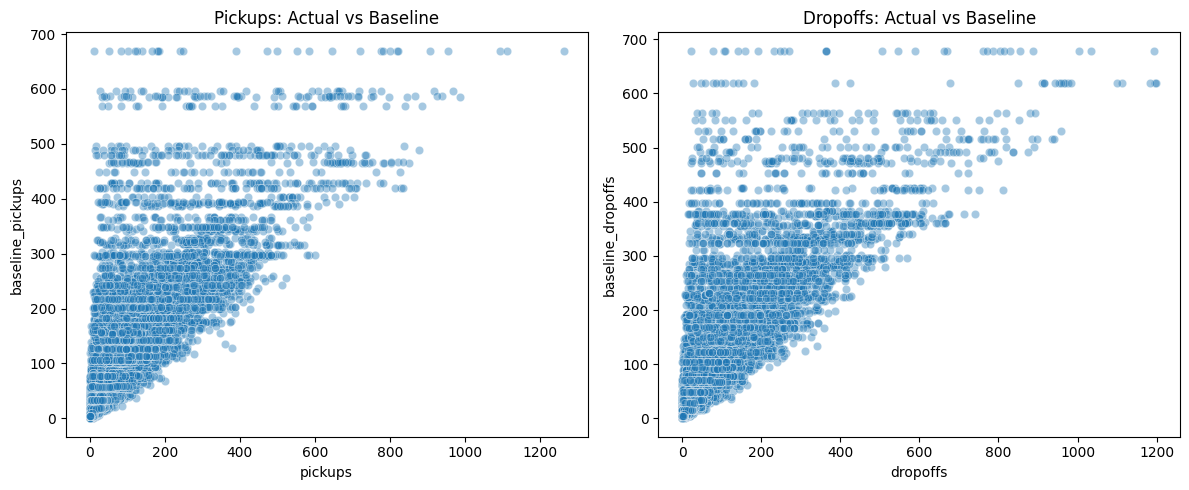

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=val_pred["pickups"], y=val_pred["baseline_pickups"], alpha=0.4)
plt.title("Pickups: Actual vs Baseline")

plt.subplot(1,2,2)
sns.scatterplot(x=val_pred["dropoffs"], y=val_pred["baseline_dropoffs"], alpha=0.4)
plt.title("Dropoffs: Actual vs Baseline")

plt.tight_layout()
plt.show()


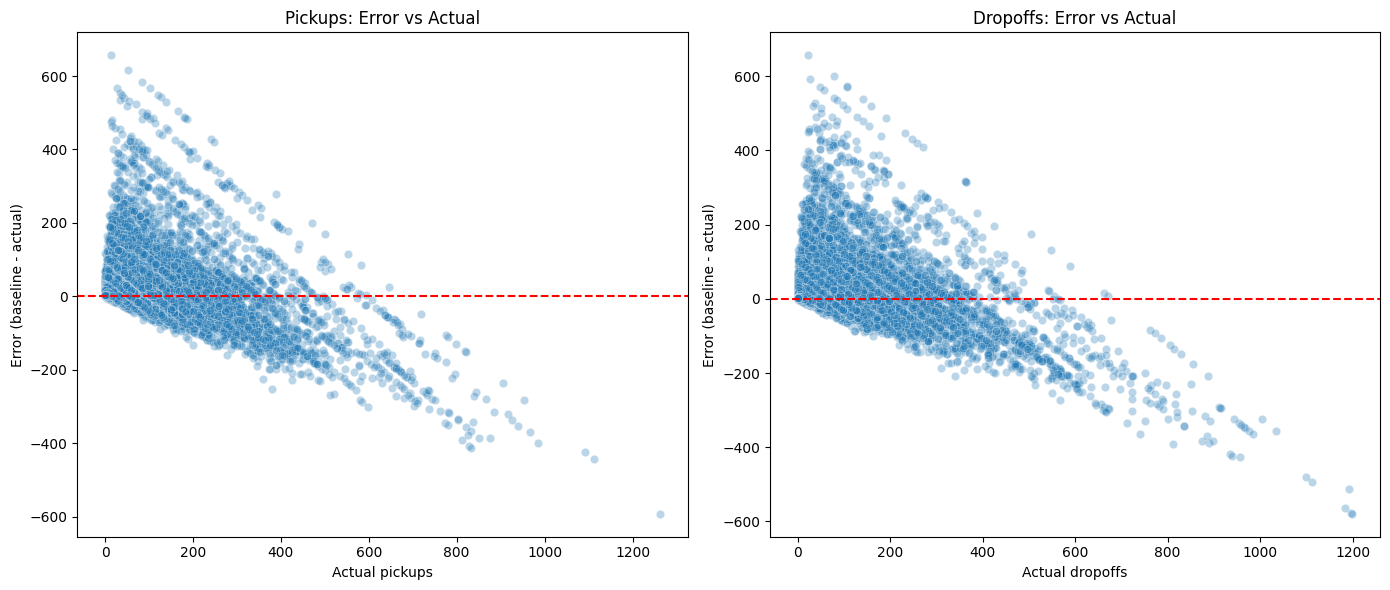

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

val_pred["error_pickups"] = val_pred["baseline_pickups"] - val_pred["pickups"]
val_pred["error_dropoffs"] = val_pred["baseline_dropoffs"] - val_pred["dropoffs"]

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.scatterplot(x=val_pred["pickups"], y=val_pred["error_pickups"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Pickups: Error vs Actual")
plt.xlabel("Actual pickups")
plt.ylabel("Error (baseline - actual)")

plt.subplot(1,2,2)
sns.scatterplot(x=val_pred["dropoffs"], y=val_pred["error_dropoffs"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Dropoffs: Error vs Actual")
plt.xlabel("Actual dropoffs")
plt.ylabel("Error (baseline - actual)")
plt.tight_layout()
plt.show()


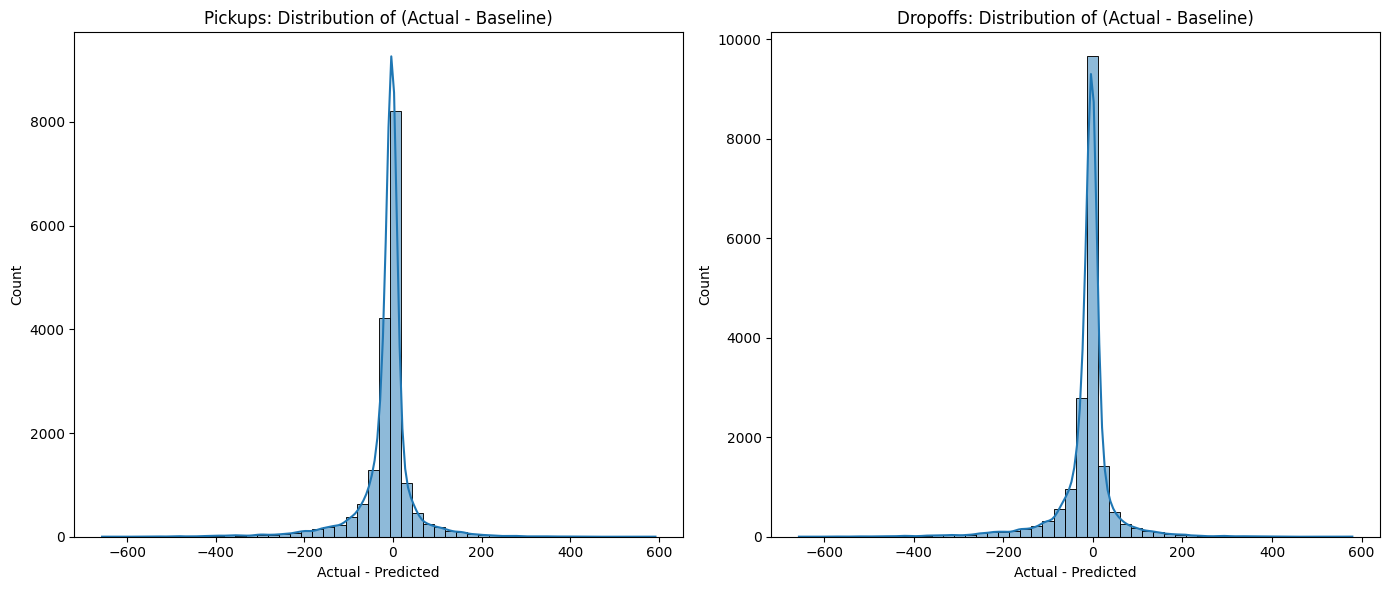

In [30]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(val_pred["pickups"] - val_pred["baseline_pickups"], bins=50, kde=True)
plt.title("Pickups: Distribution of (Actual - Baseline)")
plt.xlabel("Actual - Predicted")

plt.subplot(1,2,2)
sns.histplot(val_pred["dropoffs"] - val_pred["baseline_dropoffs"], bins=50, kde=True)
plt.title("Dropoffs: Distribution of (Actual - Baseline)")
plt.xlabel("Actual - Predicted")

plt.tight_layout()
plt.show()


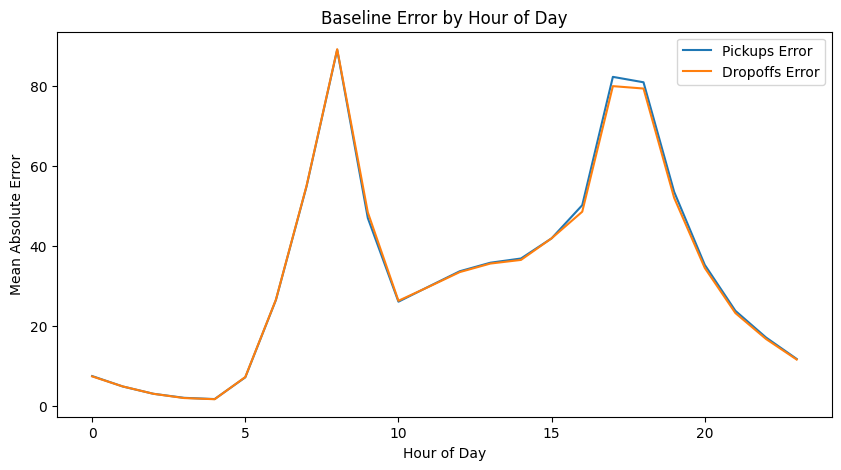

In [31]:
hourly_err = (
    val_pred
    .assign(err_pu = abs(val_pred["baseline_pickups"] - val_pred["pickups"]),
            err_do = abs(val_pred["baseline_dropoffs"] - val_pred["dropoffs"]))
    .groupby("hour_of_day")[["err_pu", "err_do"]]
    .mean()
)

plt.figure(figsize=(10,5))
plt.plot(hourly_err.index, hourly_err["err_pu"], label="Pickups Error")
plt.plot(hourly_err.index, hourly_err["err_do"], label="Dropoffs Error")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.title("Baseline Error by Hour of Day")
plt.legend()
plt.show()


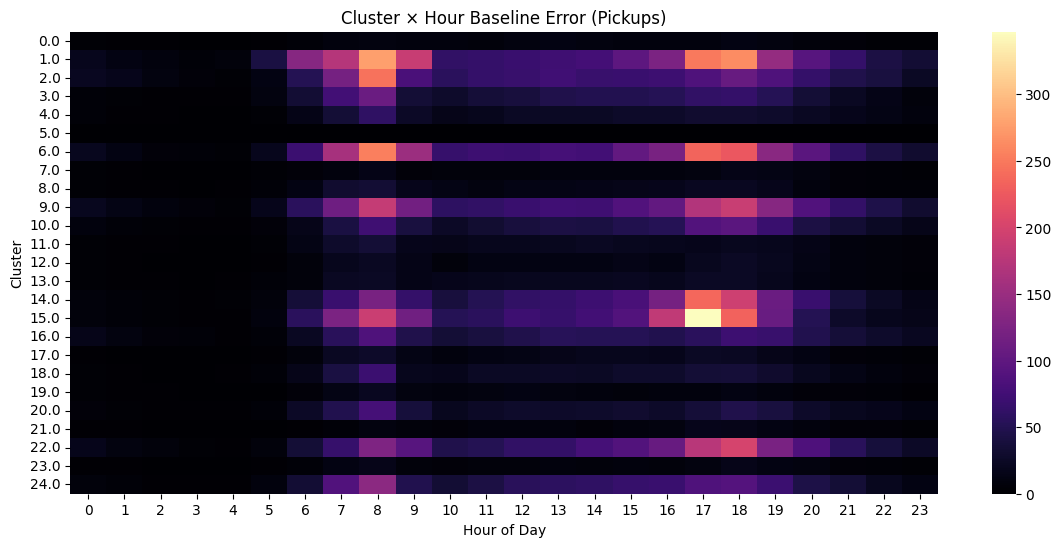

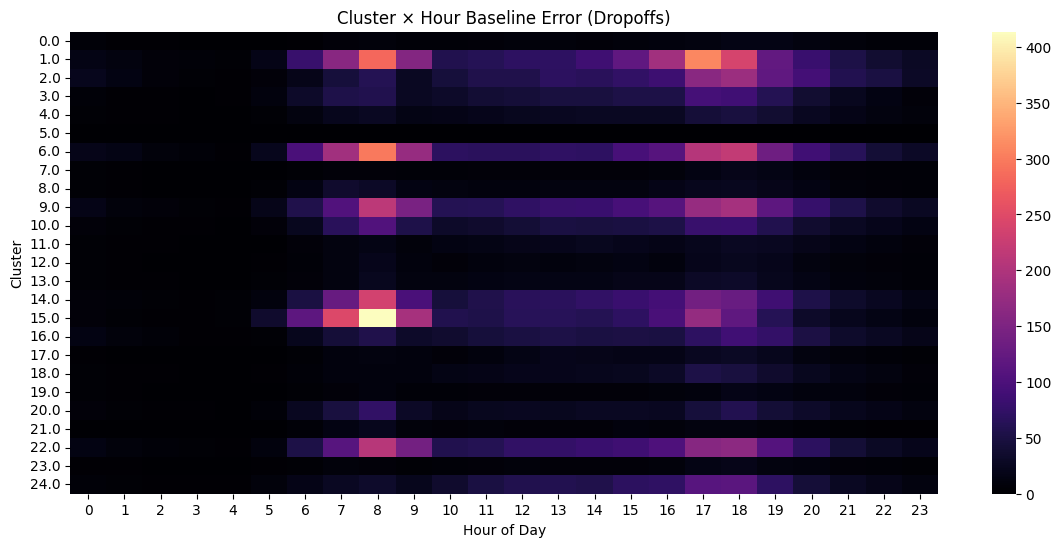

In [32]:


val_pred["abs_error_pu"] = np.abs(val_pred["baseline_pickups"] - val_pred["pickups"])
val_pred["abs_error_do"] = np.abs(val_pred["baseline_dropoffs"] - val_pred["dropoffs"])

heat = val_pred.groupby(["cluster", "hour_of_day"])[["abs_error_pu", "abs_error_do"]].mean()

plt.figure(figsize=(14,6))
sns.heatmap(heat["abs_error_pu"].unstack(), cmap="magma")
plt.title("Cluster × Hour Baseline Error (Pickups)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()

plt.figure(figsize=(14,6))
sns.heatmap(heat["abs_error_do"].unstack(), cmap="magma")
plt.title("Cluster × Hour Baseline Error (Dropoffs)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


In [33]:
df_long = val_pred.copy()

# Melt pickups
df_pick = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["pickups", "baseline_pickups"],
    var_name="type",
    value_name="value"
)
df_pick["metric"] = "pickups"

# Melt dropoffs
df_drop = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["dropoffs", "baseline_dropoffs"],
    var_name="type",
    value_name="value"
)
df_drop["metric"] = "dropoffs"

# Combine
df_melt = pd.concat([df_pick, df_drop], ignore_index=True)
df_melt

cluster                hour               type       value    metric
0          0.0 2018-11-01 00:00:00            pickups   12.000000   pickups
1          0.0 2018-11-01 01:00:00            pickups    8.000000   pickups
2          0.0 2018-11-01 02:00:00            pickups    2.000000   pickups
3          0.0 2018-11-01 03:00:00            pickups    4.000000   pickups
4          0.0 2018-11-01 04:00:00            pickups    3.000000   pickups
...        ...                 ...                ...         ...       ...
71995     24.0 2018-11-30 19:00:00  baseline_dropoffs  168.549342  dropoffs
71996     24.0 2018-11-30 20:00:00  baseline_dropoffs  103.207237  dropoffs
71997     24.0 2018-11-30 21:00:00  baseline_dropoffs   70.509868  dropoffs
71998     24.0 2018-11-30 22:00:00  baseline_dropoffs   47.855263  dropoffs
71999     24.0 2018-11-30 23:00:00  baseline_dropoffs   28.338816  dropoffs

[72000 rows x 5 columns]

Index(['cluster', 'hour', 'pickups', 'dropoffs', 'hour_of_day', 'day_of_week',
       'month', 'day', 'baseline_pickups', 'baseline_dropoffs',
       'error_pickups', 'error_dropoffs', 'abs_error_pu', 'abs_error_do'],
      dtype='object')


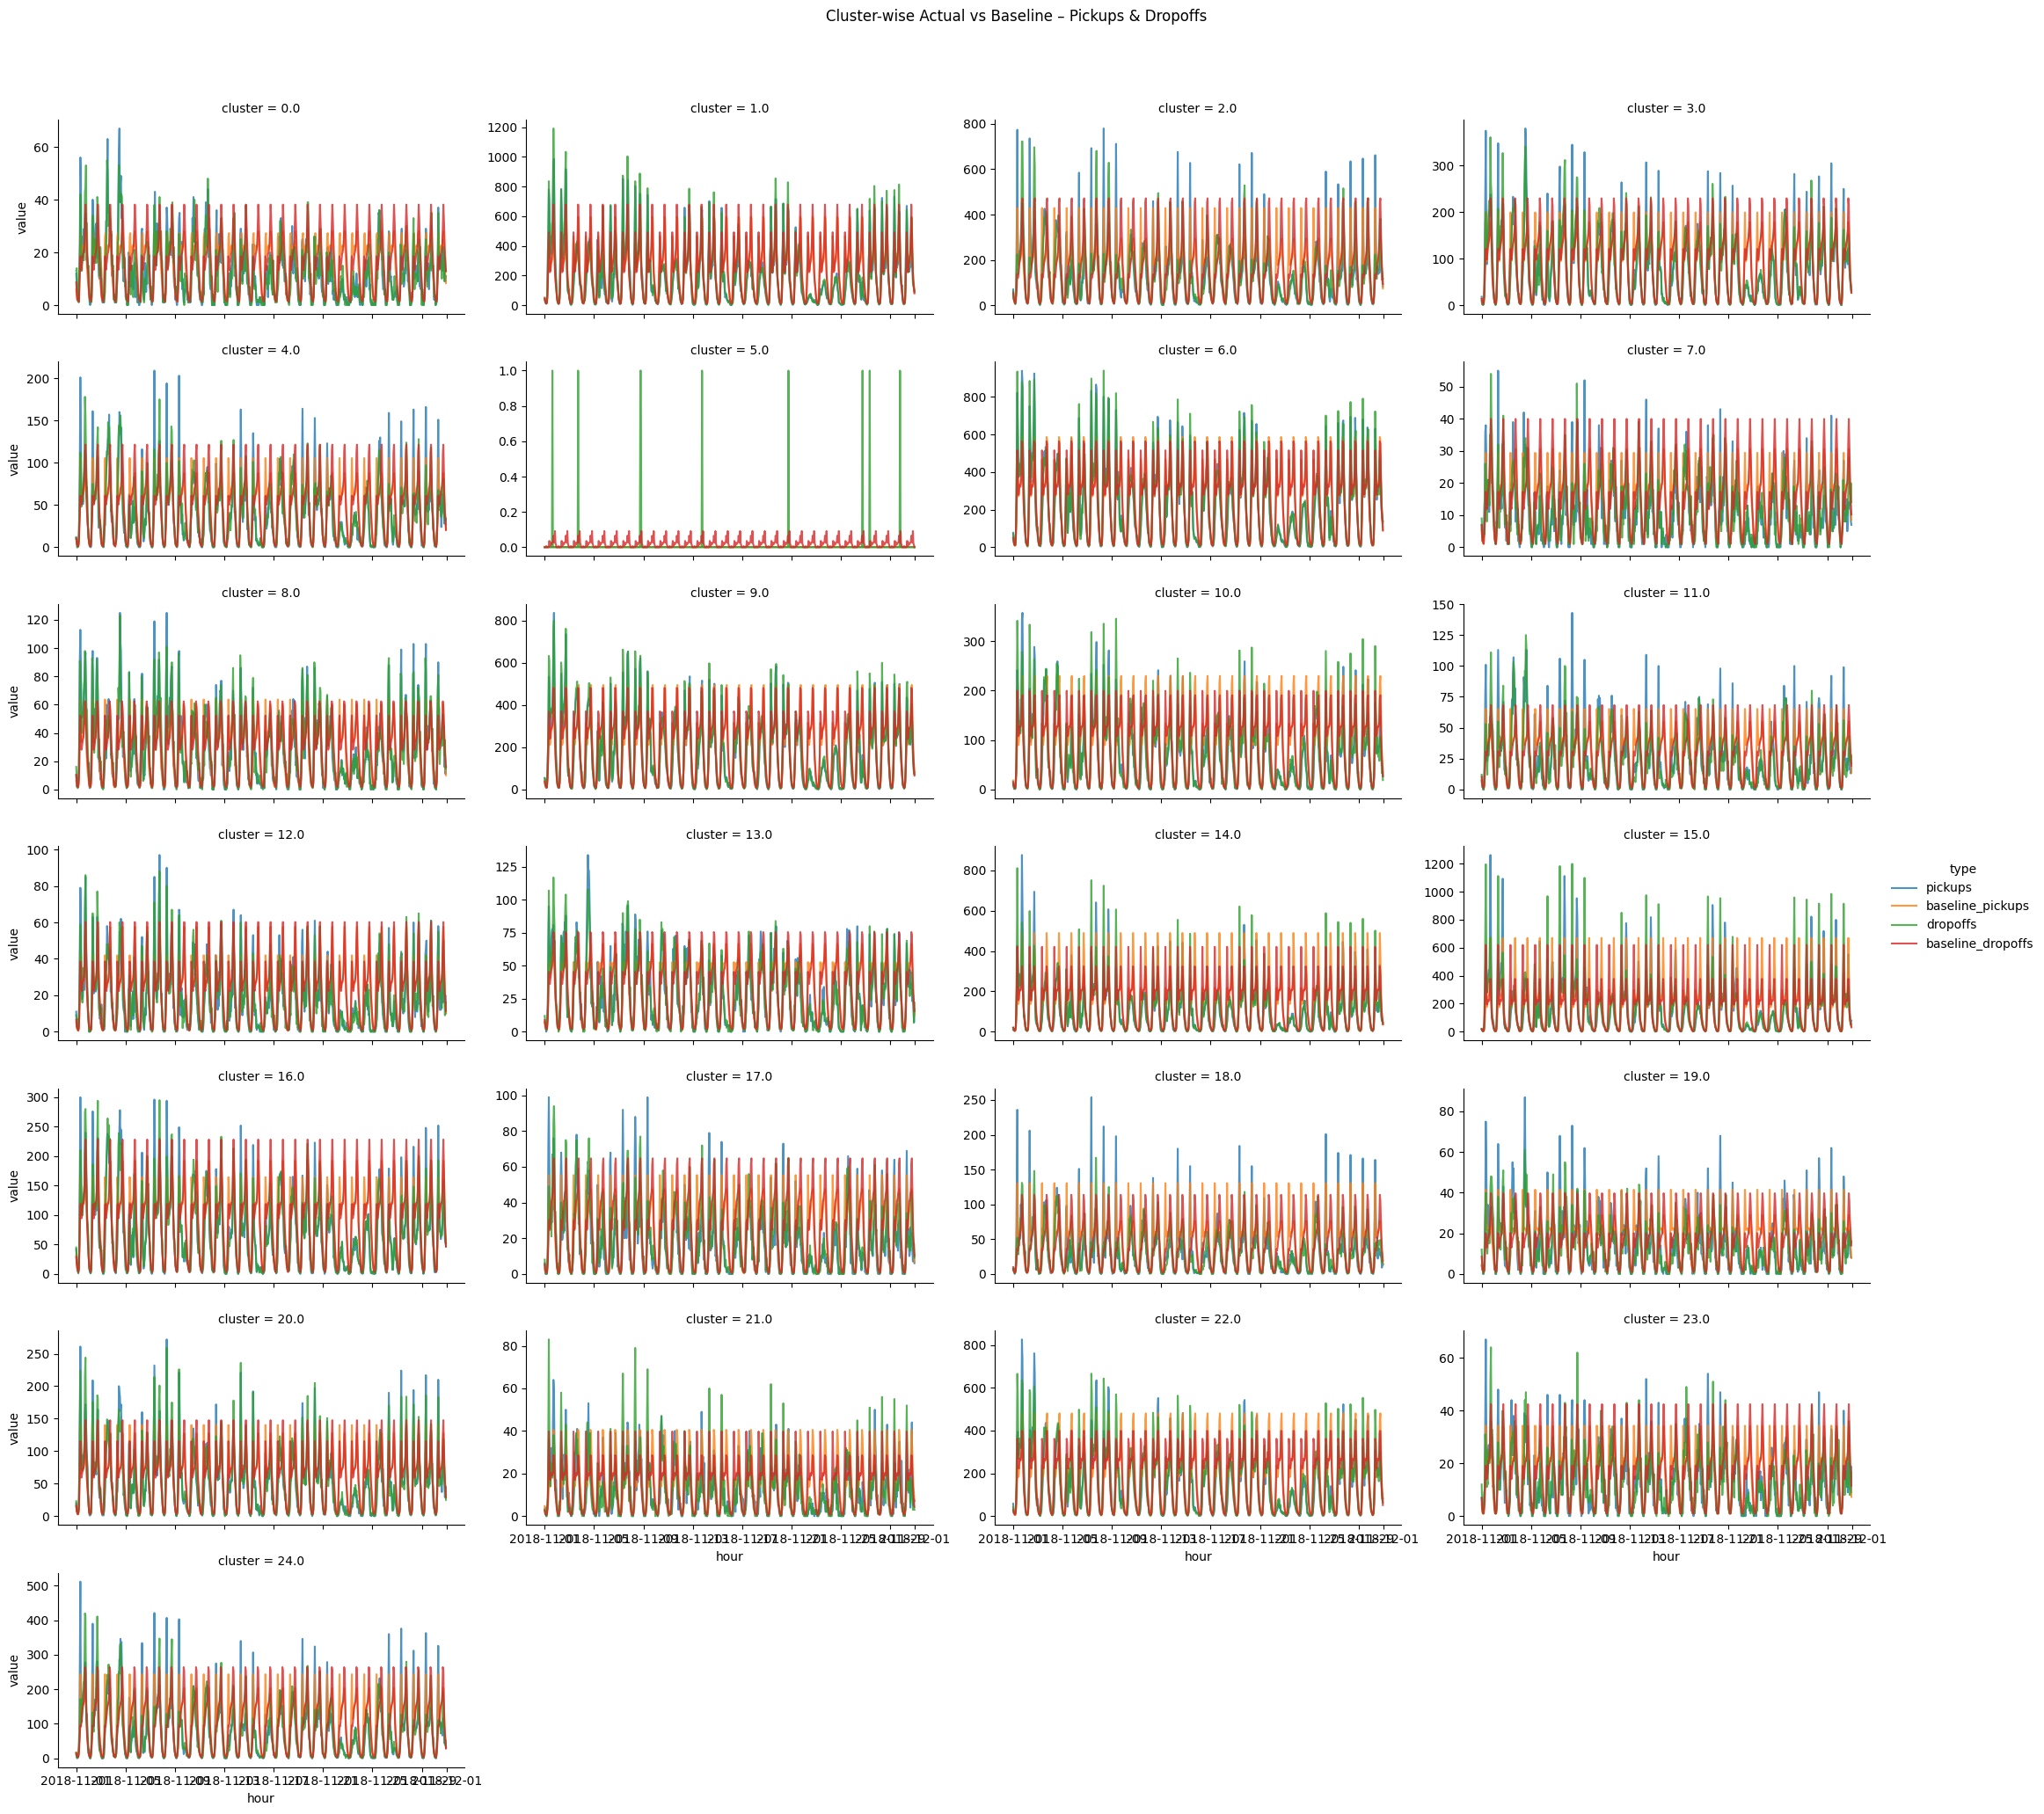

In [34]:
df_long = val_pred.copy()
print(df_long.columns)

df_long = val_pred.copy()

df_pick = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["pickups", "baseline_pickups"],
    var_name="type",
    value_name="value"
)
df_pick["metric"] = "pickups"

df_drop = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["dropoffs", "baseline_dropoffs"],
    var_name="type",
    value_name="value"
)
df_drop["metric"] = "dropoffs"
df_melt = pd.concat([df_pick, df_drop], ignore_index=True)

# Small multiple plots
g = sns.FacetGrid(
    df_melt,
    col="cluster",
    col_wrap=4,
    height=3,
    aspect=1.8,
    sharey=False,
    hue="type"     # actual vs baseline
)

g.map(sns.lineplot, "hour", "value", alpha=0.8)
g.add_legend()

plt.subplots_adjust(top=0.92)
g.fig.suptitle("Cluster-wise Actual vs Baseline – Pickups & Dropoffs")
plt.show()

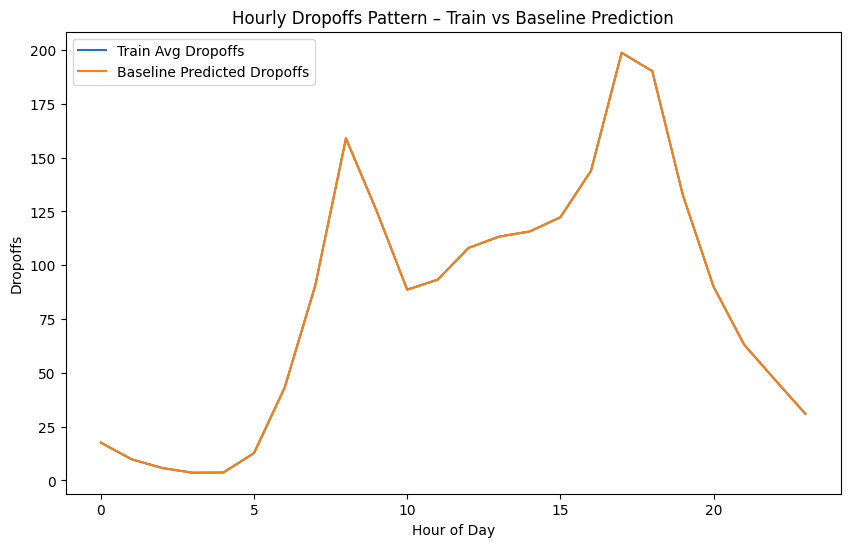

In [35]:
plt.figure(figsize=(10,6))

# Train hourly average dropoffs
sns.lineplot(
    data=train.groupby("hour_of_day")["dropoffs"].mean().reset_index(),
    x="hour_of_day", 
    y="dropoffs", 
    label="Train Avg Dropoffs"
)

# Baseline predicted dropoffs
sns.lineplot(
    data=val_pred.groupby("hour_of_day")["baseline_dropoffs"].mean().reset_index(),
    x="hour_of_day", 
    y="baseline_dropoffs", 
    label="Baseline Predicted Dropoffs"
)

plt.title("Hourly Dropoffs Pattern – Train vs Baseline Prediction")
plt.xlabel("Hour of Day")
plt.ylabel("Dropoffs")
plt.legend()
plt.show()


In [36]:
print(val_pred.columns)

Index(['cluster', 'hour', 'pickups', 'dropoffs', 'hour_of_day', 'day_of_week',
       'month', 'day', 'baseline_pickups', 'baseline_dropoffs',
       'error_pickups', 'error_dropoffs', 'abs_error_pu', 'abs_error_do'],
      dtype='object')


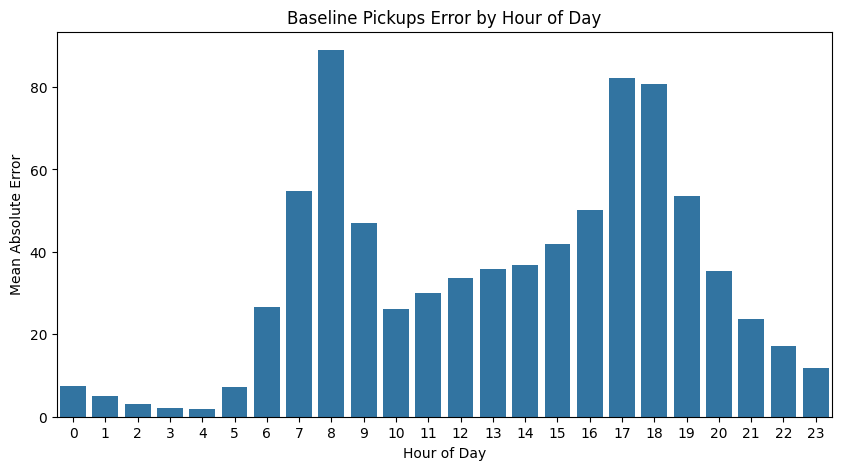

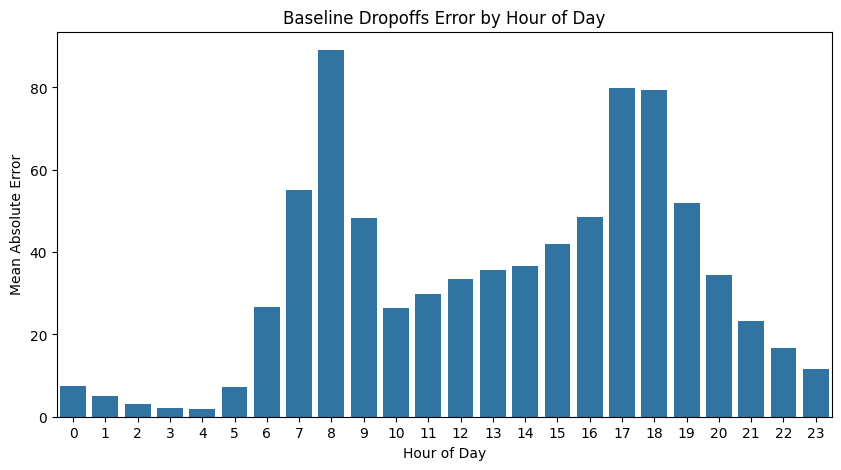

In [37]:
# Baseline weakness: pickups

val_pred["abs_error_pickups"] = (
    val_pred["pickups"] - val_pred["baseline_pickups"]
).abs()

df_err = (
    val_pred.groupby("hour_of_day")["abs_error_pickups"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=df_err, x="hour_of_day", y="abs_error_pickups")
plt.title("Baseline Pickups Error by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.show()

val_pred["abs_error_dropoffs"] = (
    val_pred["dropoffs"] - val_pred["baseline_dropoffs"]
).abs()

df_err_do = (
    val_pred.groupby("hour_of_day")["abs_error_dropoffs"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=df_err_do, x="hour_of_day", y="abs_error_dropoffs")
plt.title("Baseline Dropoffs Error by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.show()



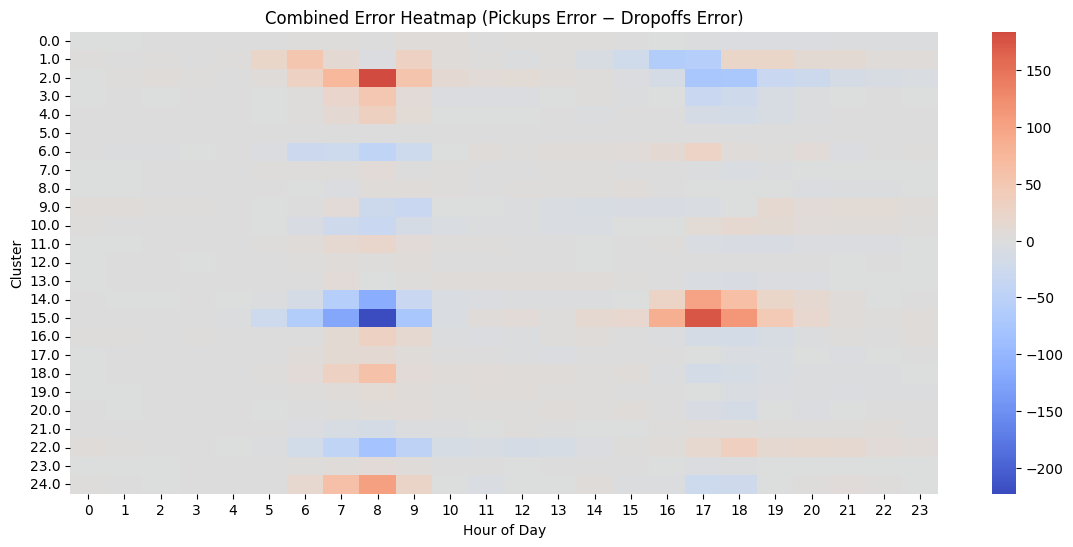

In [38]:
val_pred["combined_error"] = val_pred["abs_error_pu"] - val_pred["abs_error_do"]

heat_combined = (
    val_pred.groupby(["cluster", "hour_of_day"])["combined_error"]
            .mean()
            .reset_index()
            .pivot(index="cluster", columns="hour_of_day", values="combined_error")
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_combined, 
    cmap="coolwarm",     # red = worse for dropoffs, blue = worse for pickups
    center=0,            # zero difference is white
    linewidths=0
)
plt.title("Combined Error Heatmap (Pickups Error − Dropoffs Error)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


# Random Forest Model

In [39]:
train["lag1_pu"] = train.groupby("cluster")["pickups"].shift(1)
val["lag1_pu"]   = val.groupby("cluster")["pickups"].shift(1)
test["lag1_pu"]  = test.groupby("cluster")["pickups"].shift(1)

# Lag for dropoffs
train["lag1_do"] = train.groupby("cluster")["dropoffs"].shift(1)
val["lag1_do"]   = val.groupby("cluster")["dropoffs"].shift(1)
test["lag1_do"]  = test.groupby("cluster")["dropoffs"].shift(1)

# Fill NA
train.fillna(0, inplace=True)
val.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [40]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

feature_cols = [
    "cluster",
    "hour_of_day",
    "day_of_week",
    "month",
    "lag1_pu",
    "lag1_do"
]

X_train = train[feature_cols]
y_train = train[["pickups", "dropoffs"]]

multi_rf = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        n_jobs=-1,
        random_state=42
    )
)

multi_rf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=15,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [41]:
val[["pred_pickups", "pred_dropoffs"]] = multi_rf.predict(val[feature_cols])
test[["pred_pickups", "pred_dropoffs"]] = multi_rf.predict(test[feature_cols])


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Pickups
mae_pu = mean_absolute_error(val["pickups"], val["pred_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val["pickups"], val["pred_pickups"]))

# Dropoffs
mae_do = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

print("RF Multi-out Pickups MAE:", mae_pu)
print("RF Multi-out Pickups RMSE:", rmse_pu)
print("RF Multi-out Dropoffs MAE:", mae_do)
print("RF Multi-out Dropoffs RMSE:", rmse_do)


RF Multi-out Pickups MAE: 11.195470345426278
RF Multi-out Pickups RMSE: 22.313386542928715
RF Multi-out Dropoffs MAE: 11.299267301887664
RF Multi-out Dropoffs RMSE: 22.333241945660284


In [43]:
print([col for col in train.columns if 'lag' in col])



['lag1_pu', 'lag1_do']


In [44]:
from xgboost import XGBRegressor
feature_cols = ["cluster", "hour_of_day", "day_of_week", "month", "lag1_pu", "lag1_do"]
xgb_pu = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_pu.fit(
    train[feature_cols], train["pickups"],
    eval_set=[(val[feature_cols], val["pickups"])],
    #early_stopping_rounds=50,
    verbose=False
)
xgb_do = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_do.fit(
    train[feature_cols], train["dropoffs"],
    eval_set=[(val[feature_cols], val["dropoffs"])],
    #early_stopping_rounds=50,
    verbose=False
)
val["pred_pickups"]  = xgb_pu.predict(val[feature_cols])
val["pred_dropoffs"] = xgb_do.predict(val[feature_cols])


In [45]:
mae_pu = mean_absolute_error(val["pickups"], val["pred_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val["pickups"], val["pred_pickups"]))

mae_do = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

val.head()

print("XGBoost Pickups MAE:", mae_pu)
print("XGBoost Pickups RMSE:", rmse_pu)
print("XGBoost Dropoffs MAE:", mae_do)
print("XGBoost Dropoffs RMSE:", rmse_do)
val.head(100)

XGBoost Pickups MAE: 11.384251594543457
XGBoost Pickups RMSE: 22.46067662891985
XGBoost Dropoffs MAE: 11.810187339782715
XGBoost Dropoffs RMSE: 23.39470180946759


cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0       0.0 2018-11-01 00:00:00       12        13            0            3   
1       0.0 2018-11-01 01:00:00        8        14            1            3   
2       0.0 2018-11-01 02:00:00        2         8            2            3   
3       0.0 2018-11-01 03:00:00        4         6            3            3   
4       0.0 2018-11-01 04:00:00        3         4            4            3   
..      ...                 ...      ...       ...          ...          ...   
95      0.0 2018-11-04 23:00:00       10         7           23            6   
96      0.0 2018-11-05 00:00:00        3         9            0            0   
97      0.0 2018-11-05 01:00:00        3         2            1            0   
98      0.0 2018-11-05 02:00:00        4         3            2            0   
99      0.0 2018-11-05 03:00:00        0         0            3            0   

    month  day  lag1_pu  lag1_do  pred_pickups  pred_dropoffs  
0      11    1      0.0      0.0      1.913507       0.121782  
1      11    1     12.0     13.0      6.375161       6.990005  
2      11    1      8.0     14.0      4.631106       6.901748  
3      11    1      2.0      8.0      1.870135       3.333212  
4      11    1      4.0      6.0      4.707294       5.302674  
..    ...  ...      ...      ...           ...            ...  
95     11    4      9.0     18.0      8.038548      14.147742  
96     11    5     10.0      7.0      5.140512       5.460797  
97     11    5      3.0      9.0      2.118914       3.700920  
98     11    5      3.0      2.0      1.356028       0.964252  
99     11    5      4.0      3.0      1.706814       1.843511  

[100 rows x 12 columns]

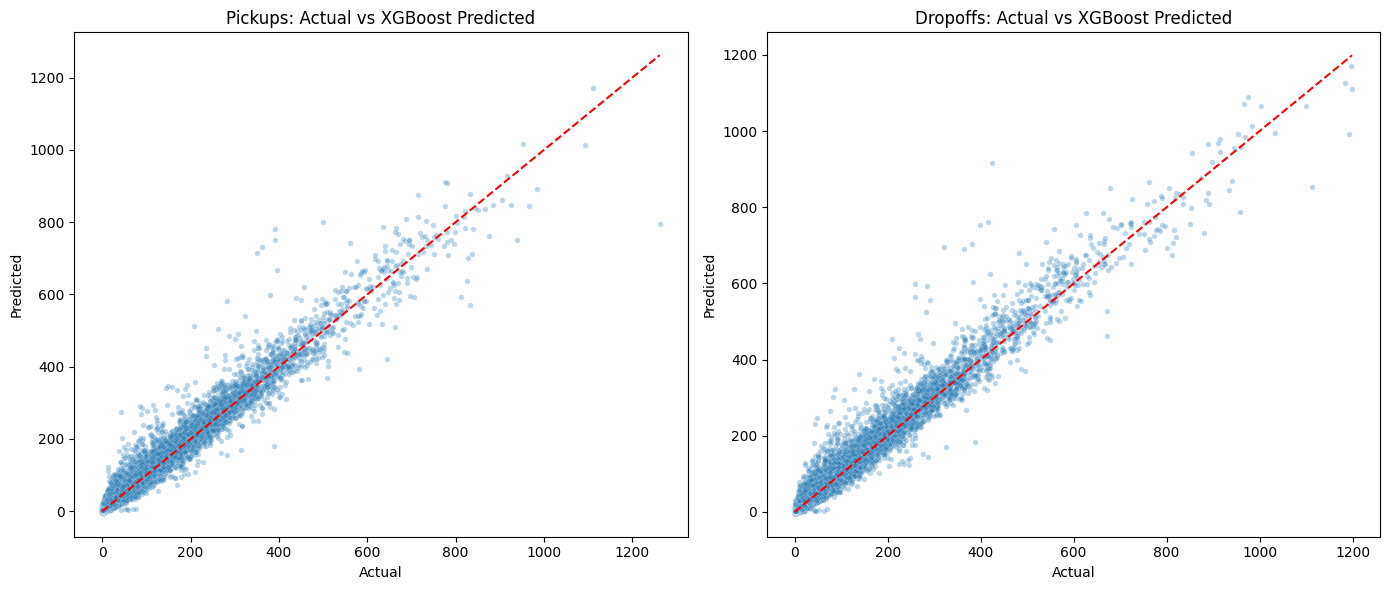

In [46]:
plt.figure(figsize=(14,6))

# PICKUPS
plt.subplot(1,2,1)
sns.scatterplot(x=val["pickups"], y=val["pred_pickups"], alpha=0.3, s=15)
plt.plot([0, max(val["pickups"])], [0, max(val["pickups"])], 'r--')
plt.title("Pickups: Actual vs XGBoost Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# DROPOFFS
plt.subplot(1,2,2)
sns.scatterplot(x=val["dropoffs"], y=val["pred_dropoffs"], alpha=0.3, s=15)
plt.plot([0, max(val["dropoffs"])], [0, max(val["dropoffs"])], 'r--')
plt.title("Dropoffs: Actual vs XGBoost Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

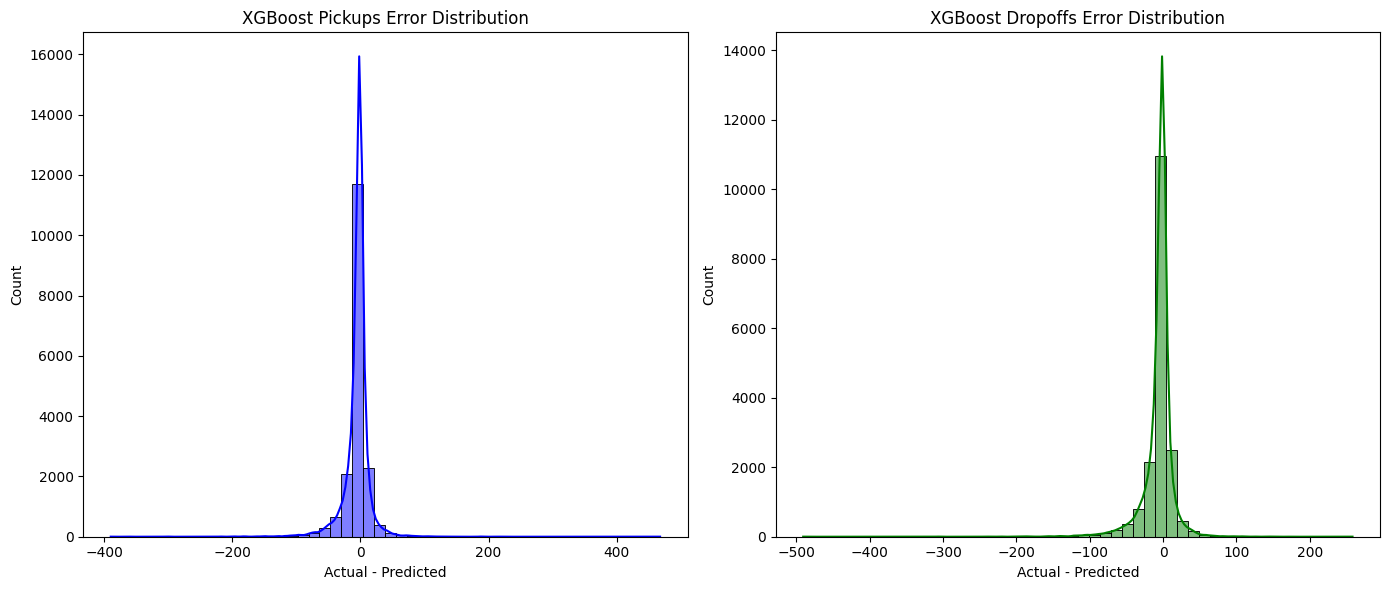

In [47]:
plt.figure(figsize=(14,6))

# PICKUPS
plt.subplot(1,2,1)
sns.histplot(val["pickups"] - val["pred_pickups"], bins=50, kde=True, color="blue")
plt.title("XGBoost Pickups Error Distribution")
plt.xlabel("Actual - Predicted")

# DROPOFFS
plt.subplot(1,2,2)
sns.histplot(val["dropoffs"] - val["pred_dropoffs"], bins=50, kde=True, color="green")
plt.title("XGBoost Dropoffs Error Distribution")
plt.xlabel("Actual - Predicted")

plt.tight_layout()
plt.show()


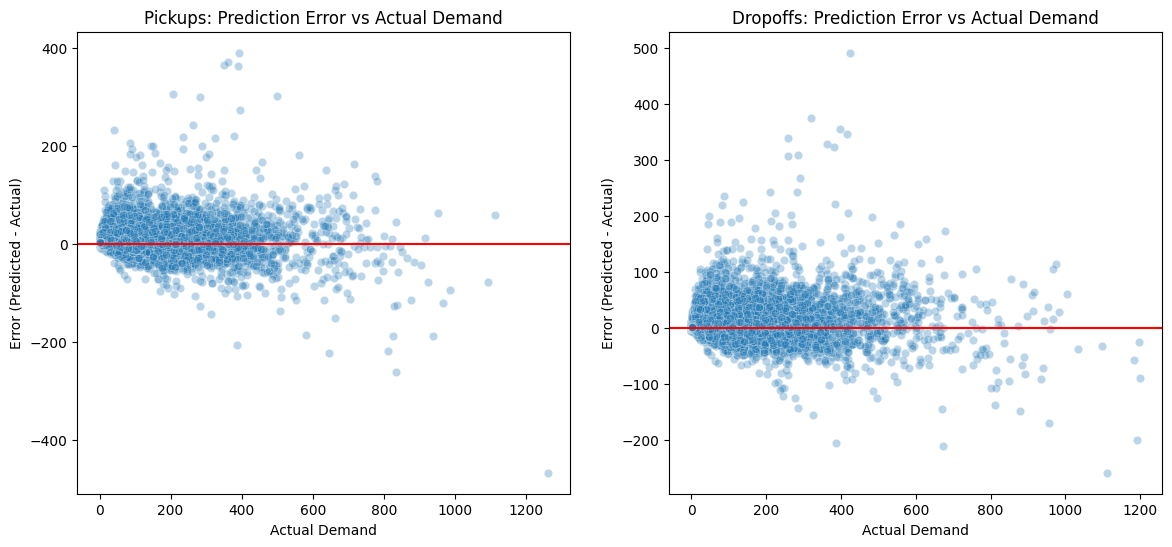

In [48]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.scatterplot(
    x=val["pickups"],
    y=val["pred_pickups"] - val["pickups"],
    alpha=0.3
)
plt.axhline(0, color="red")
plt.title("Pickups: Prediction Error vs Actual Demand")
plt.xlabel("Actual Demand")
plt.ylabel("Error (Predicted - Actual)")

plt.subplot(1,2,2)
sns.scatterplot(
    x=val["dropoffs"],
    y=val["pred_dropoffs"] - val["dropoffs"],
    alpha=0.3
)
plt.axhline(0, color="red")
plt.title("Dropoffs: Prediction Error vs Actual Demand")
plt.xlabel("Actual Demand")
plt.ylabel("Error (Predicted - Actual)")
plt.show()


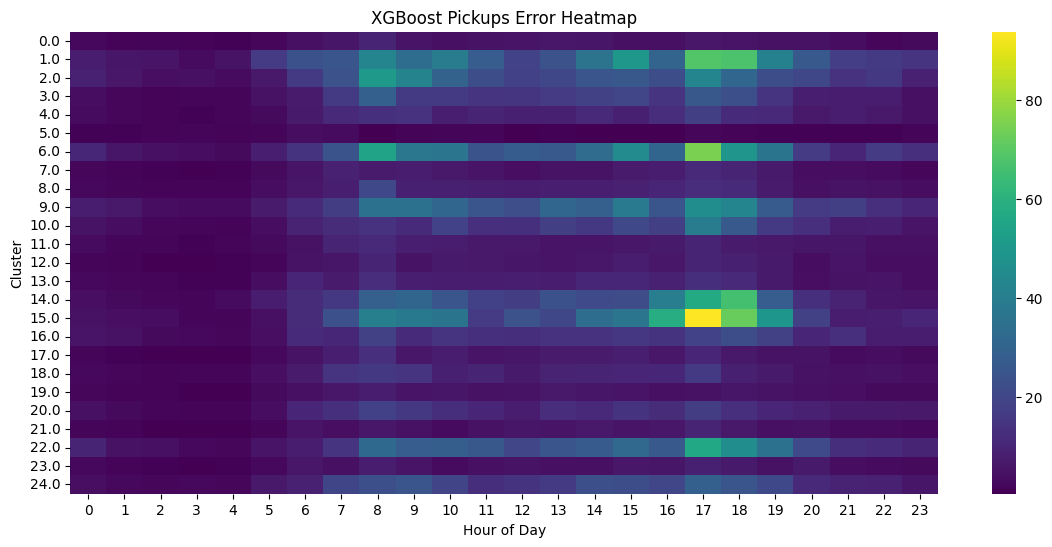

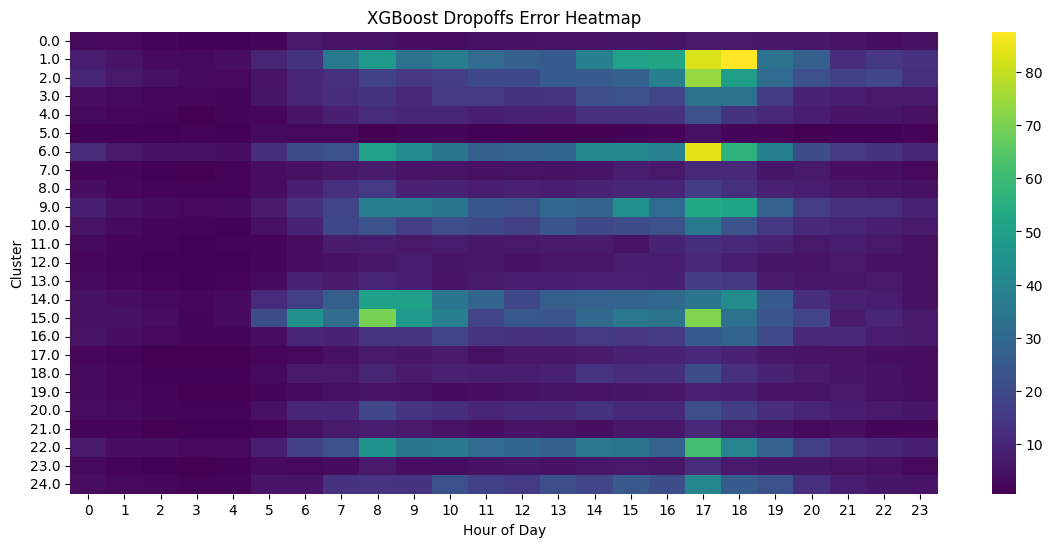

In [49]:
val["abs_err_pu"] = abs(val["pickups"] - val["pred_pickups"])
val["abs_err_do"] = abs(val["dropoffs"] - val["pred_dropoffs"])

heat_pu = (
    val.groupby(["cluster", "hour_of_day"])["abs_err_pu"]
       .mean()
       .unstack()
)

heat_do = (
    val.groupby(["cluster", "hour_of_day"])["abs_err_do"]
       .mean()
       .unstack()
)

plt.figure(figsize=(14,6))
sns.heatmap(heat_pu, cmap="viridis")
plt.title("XGBoost Pickups Error Heatmap")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()

plt.figure(figsize=(14,6))
sns.heatmap(heat_do, cmap="viridis")
plt.title("XGBoost Dropoffs Error Heatmap")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


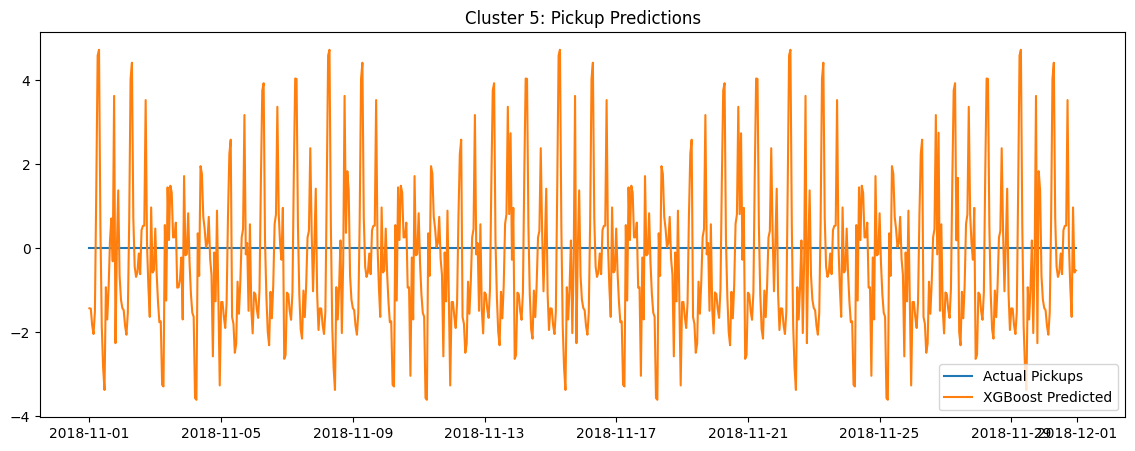

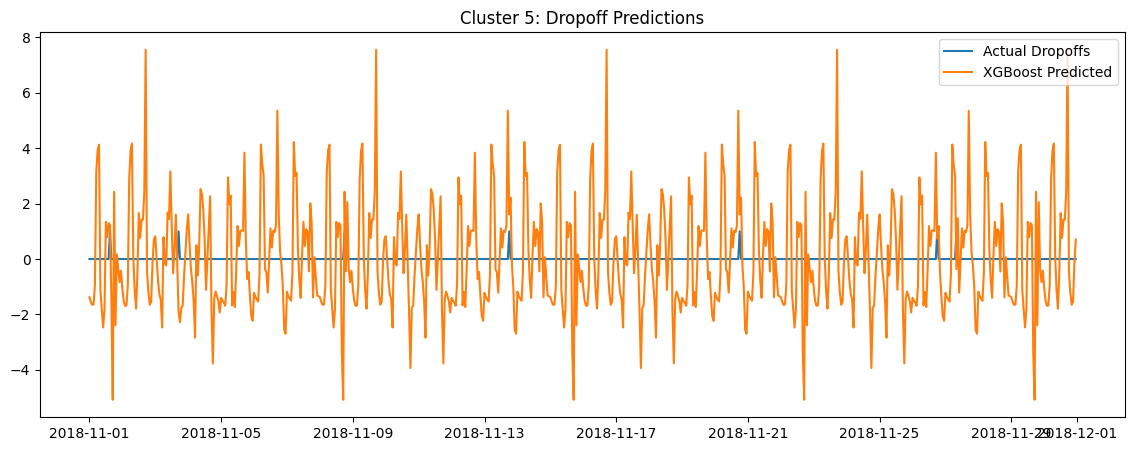

In [50]:
cluster_id = 5
dfc = val[val["cluster"] == cluster_id]

plt.figure(figsize=(14,5))
plt.plot(dfc["hour"], dfc["pickups"], label="Actual Pickups")
plt.plot(dfc["hour"], dfc["pred_pickups"], label="XGBoost Predicted")
plt.legend()
plt.title(f"Cluster {cluster_id}: Pickup Predictions")
plt.show()
plt.figure(figsize=(14,5))
plt.plot(dfc["hour"], dfc["dropoffs"], label="Actual Dropoffs")
plt.plot(dfc["hour"], dfc["pred_dropoffs"], label="XGBoost Predicted")
plt.legend()
plt.title(f"Cluster {cluster_id}: Dropoff Predictions")
plt.show()

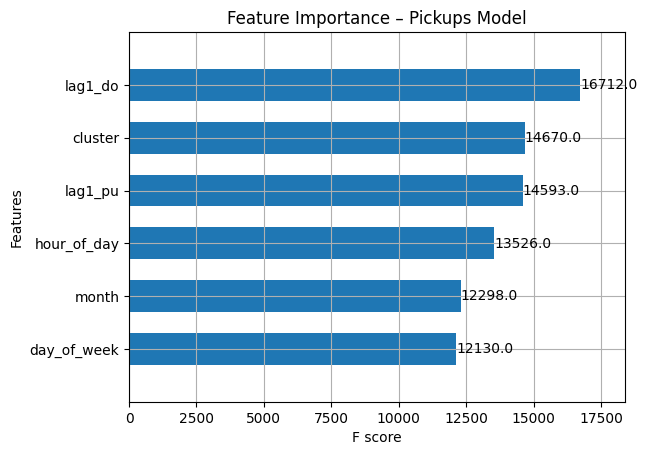

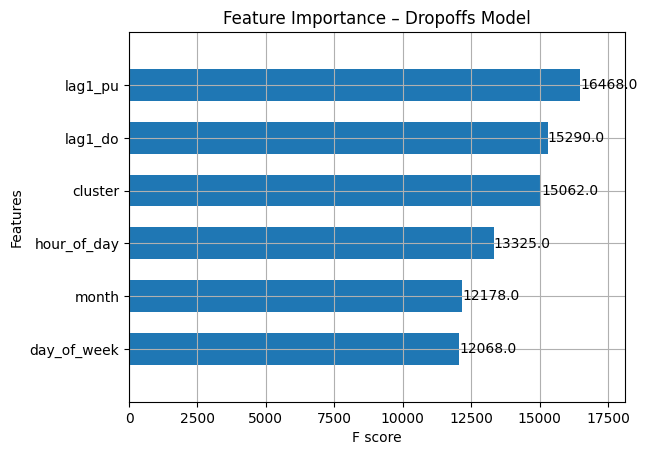

In [51]:
import xgboost as xgb
xgb.plot_importance(xgb_pu, height=0.6)
plt.title("Feature Importance – Pickups Model")
plt.show()

xgb.plot_importance(xgb_do, height=0.6)
plt.title("Feature Importance – Dropoffs Model")
plt.show()

# 24-Hour Ahead Forecasting

In [52]:
feature_cols = ["cluster", "hour_of_day", "day_of_week", "month", 
                "lag1_pu", "lag1_do"]
def forecast_next_24h(cluster_id, last_day_df, xgb_pu, xgb_do):
    """
    last_day_df: last day of available data (Nov 30 for validation, Dec 31 for test)
    xgb_pu: trained XGBoost pickups model
    xgb_do: trained XGBoost dropoffs model
    """
    
    # Extract last known values
    last_row = last_day_df[last_day_df["cluster"] == cluster_id].sort_values("hour").iloc[-1]

    lag_pu = last_row["pickups"]
    lag_do = last_row["dropoffs"]
    
    # Start from the next day at 00:00
    next_day_start = last_row["hour"].replace(hour=0) + pd.Timedelta(days=1)

    forecasts = []
    
    for h in range(24):
        current_hour = next_day_start + pd.Timedelta(hours=h)
        
        # Build feature row
        X = pd.DataFrame({
            "cluster": [cluster_id],
            "hour_of_day": [current_hour.hour],
            "day_of_week": [current_hour.dayofweek],
            "month": [current_hour.month],
            "lag1_pu": [lag_pu],
            "lag1_do": [lag_do]
        })

        # Predict pickups and dropoffs
        pred_pu = xgb_pu.predict(X)[0]
        pred_do = xgb_do.predict(X)[0]

        # Save prediction
        forecasts.append({
            "cluster": cluster_id,
            "forecast_hour": current_hour,
            "pred_pickups": pred_pu,
            "pred_dropoffs": pred_do
        })

        # Update lags for next hour
        lag_pu = pred_pu
        lag_do = pred_do
    
    return pd.DataFrame(forecasts)

In [53]:
clusters = sorted(train["cluster"].unique())

# last day available in validation set (Nov 30)
last_day = val[val["hour"].dt.date == val["hour"].dt.date.max()]

all_forecasts = []

for cid in clusters:
    df_fc = forecast_next_24h(
        cluster_id=cid,
        last_day_df=last_day,
        xgb_pu=xgb_pu,
        xgb_do=xgb_do
    )
    all_forecasts.append(df_fc)

final_forecasts = pd.concat(all_forecasts, ignore_index=True)
final_forecasts.head(30)

cluster       forecast_hour  pred_pickups  pred_dropoffs
0       0.0 2018-12-01 00:00:00      8.854665      11.689000
1       0.0 2018-12-01 01:00:00      5.646782       8.058166
2       0.0 2018-12-01 02:00:00      3.668258       5.480487
3       0.0 2018-12-01 03:00:00      2.598516       2.736619
4       0.0 2018-12-01 04:00:00      2.005398       1.825722
5       0.0 2018-12-01 05:00:00      2.212417      -1.358971
6       0.0 2018-12-01 06:00:00      4.600200       0.086958
7       0.0 2018-12-01 07:00:00      3.570518       2.467762
8       0.0 2018-12-01 08:00:00      3.388496       2.613102
9       0.0 2018-12-01 09:00:00      8.554658       4.320585
10      0.0 2018-12-01 10:00:00     12.883699       8.430263
11      0.0 2018-12-01 11:00:00     18.031252      14.230252
12      0.0 2018-12-01 12:00:00     24.350393      18.549629
13      0.0 2018-12-01 13:00:00     26.919540      21.167295
14      0.0 2018-12-01 14:00:00     27.104383      23.342592
15      0.0 2018-12-01 15:00:00     28.411783      25.119755
16      0.0 2018-12-01 16:00:00     25.590935      25.510157
17      0.0 2018-12-01 17:00:00     26.778158      26.478418
18      0.0 2018-12-01 18:00:00     21.774918      27.015171
19      0.0 2018-12-01 19:00:00     18.579611      22.792763
20      0.0 2018-12-01 20:00:00     14.318244      17.914368
21      0.0 2018-12-01 21:00:00     13.884210      17.012329
22      0.0 2018-12-01 22:00:00     12.318199      16.793213
23      0.0 2018-12-01 23:00:00     11.015557      16.035988
24      1.0 2018-12-01 00:00:00     57.265217      59.371536
25      1.0 2018-12-01 01:00:00     37.606224      36.712971
26      1.0 2018-12-01 02:00:00     23.475500      22.382460
27      1.0 2018-12-01 03:00:00     15.556348      14.944889
28      1.0 2018-12-01 04:00:00     13.209212      11.966910
29      1.0 2018-12-01 05:00:00     19.089548      15.784624

In [54]:
df = final_forecasts.copy()

# Compute net flow (arrivals - departures)
df["net"] = df["pred_dropoffs"] - df["pred_pickups"]

rows = []

for cid in sorted(df["cluster"].unique()):
    
    sub = df[df["cluster"] == cid].sort_values("forecast_hour")
    
    # cumulative net flow
    sub["cumulative"] = sub["net"].cumsum()
    
    # most negative point = number of bikes needed
    min_cum = sub["cumulative"].min()
    required = max(0, -min_cum)
    
    rows.append({
        "cluster": int(cid),
        "required_initial_bikes": required
    })

final_table = pd.DataFrame(rows)

final_table = final_table.sort_values("cluster").reset_index(drop=True)

final_table


cluster  required_initial_bikes
0         0               34.422260
1         1               69.220795
2         2              299.299194
3         3               29.377676
4         4               37.304070
5         5               32.311661
6         6               14.504303
7         7               30.971739
8         8               47.738632
9         9               24.938999
10       10                1.084761
11       11               43.993443
12       12                8.819069
13       13               31.787041
14       14                0.000000
15       15              150.029602
16       16               30.796692
17       17               23.752613
18       18               91.756241
19       19               37.805428
20       20               48.545349
21       21                1.655719
22       22               14.222165
23       23               21.686476
24       24              170.350464

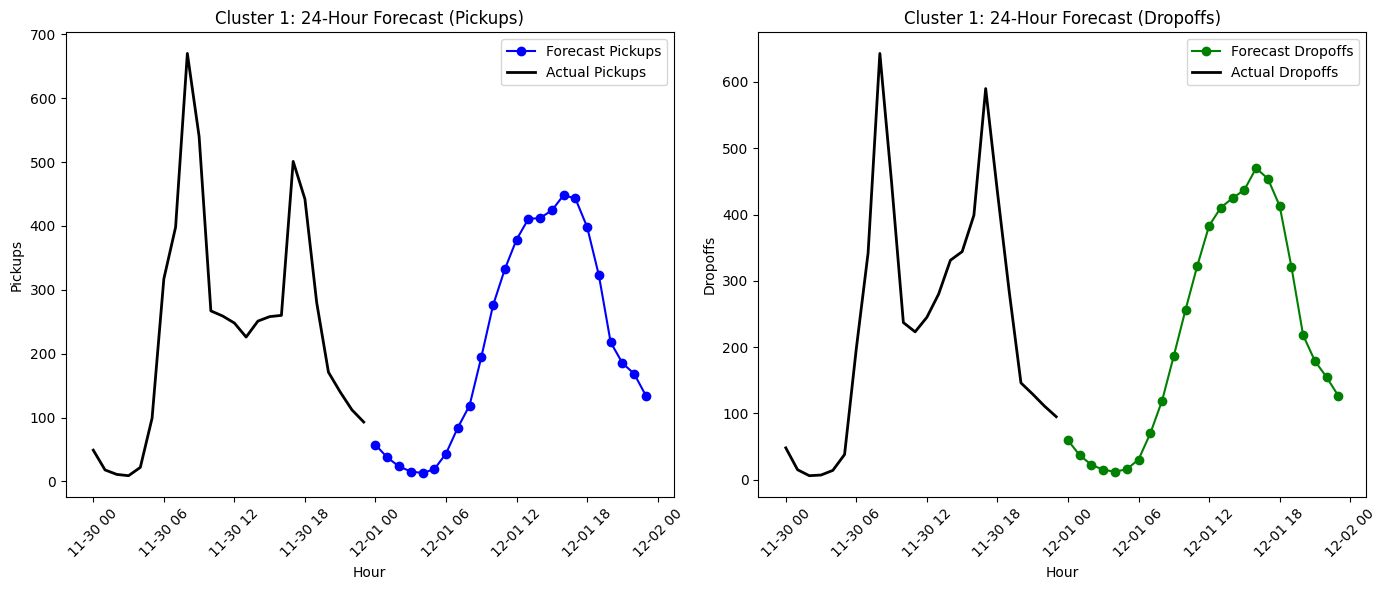

In [55]:
def plot_24h_forecast(cluster_id, forecast_df, actual_df=None):
    """
    forecast_df: output of your 24-hour forecasting function
    actual_df: actual pickups/dropoffs for that day (optional)
    """

    df_fc = forecast_df[forecast_df["cluster"] == cluster_id].copy()

    plt.figure(figsize=(14,6))

    # --- Pickups ---
    plt.subplot(1,2,1)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_pickups"],
             label="Forecast Pickups", color='blue', marker='o')

    if actual_df is not None:
        df_actual = actual_df[actual_df["cluster"] == cluster_id]
        plt.plot(df_actual["hour"], df_actual["pickups"],
                 label="Actual Pickups", color='black', linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24-Hour Forecast (Pickups)")
    plt.xlabel("Hour")
    plt.ylabel("Pickups")
    plt.xticks(rotation=45)
    plt.legend()

    # --- Dropoffs ---
    plt.subplot(1,2,2)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_dropoffs"],
             label="Forecast Dropoffs", color='green', marker='o')

    if actual_df is not None:
        plt.plot(df_actual["hour"], df_actual["dropoffs"],
                 label="Actual Dropoffs", color='black', linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24-Hour Forecast (Dropoffs)")
    plt.xlabel("Hour")
    plt.ylabel("Dropoffs")
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_24h_forecast(cluster_id=1, 
                  forecast_df=final_forecasts,
                  actual_df=val[val["hour"].dt.date == val["hour"].dt.date.max()])

Actual rows: 24 Forecast rows: 24


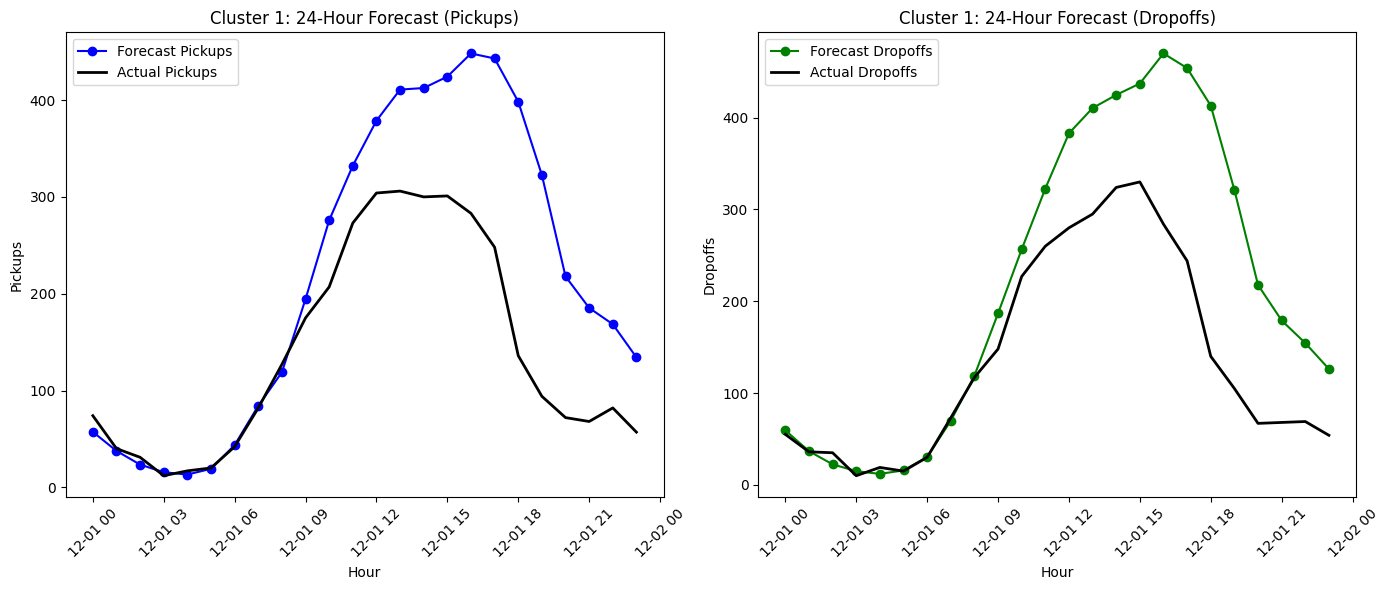

In [56]:

cluster_id = 1                 # choose the cluster you want
target_date = pd.to_datetime("2018-12-01").date()

# 1) real dec1 stats
actual_dec1 = test[
    (test["cluster"] == cluster_id) &
    (test["hour"].dt.date == target_date)
].copy()

# 2) forecast dec1 stats
forecast_dec1 = final_forecasts[
    (final_forecasts["cluster"] == cluster_id) &
    (final_forecasts["forecast_hour"].dt.date == target_date)
].copy()

print("Actual rows:", len(actual_dec1), "Forecast rows:", len(forecast_dec1))

plot_24h_forecast(
    cluster_id=cluster_id,
    forecast_df=forecast_dec1,
    actual_df=actual_dec1,
)


### Retrying 24H forecast while accounting for weather data

In [57]:
# Merge hourly weather into cluster time series

cluster_ts = cluster_ts.merge(
    weather_hourly[[
        "hour",
        "temp_celsius",
        "is_dry",
        "wind_kmh",
        "cycling_score"
    ]],
    on="hour",
    how="left"
)

print(cluster_ts.head())
print("Columns in cluster_ts:", cluster_ts.columns)


   cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0      0.0 2018-01-01 00:00:00        1         2            0            0   
1      0.0 2018-01-01 01:00:00        0         0            1            0   
2      0.0 2018-01-01 02:00:00        0         0            2            0   
3      0.0 2018-01-01 03:00:00        3         3            3            0   
4      0.0 2018-01-01 04:00:00        0         0            4            0   

   month  day  temp_celsius  is_dry   wind_kmh  cycling_score  
0      1    1    -13.665384       1  58.444614      30.000479  
1      1    1    -13.823076       1  58.679996      30.000431  
2      1    1    -14.042308       1  56.519993      30.000370  
3      1    1    -14.261538       1  54.761536      30.000319  
4      1    1    -14.446154       1  56.990768      30.000280  
Columns in cluster_ts: Index(['cluster', 'hour', 'pickups', 'dropoffs', 'hour_of_day', 'day_of_week',
       'month', 'day', 'temp_celsius', 

In [58]:
# Train: Jan–Oct
train = cluster_ts[cluster_ts["month"] <= 10].reset_index(drop=True)

# Validation: Nov
val = cluster_ts[cluster_ts["month"] == 11].reset_index(drop=True)

# Test: Dec
test = cluster_ts[cluster_ts["month"] == 12].reset_index(drop=True)

print("Train rows:", len(train))
print("Validation rows:", len(val))
print("Test rows:", len(test))


Train rows: 182400
Validation rows: 18000
Test rows: 18600


In [59]:
# add lag  per cluster

for df_ in (train, val, test):
    df_.sort_values(["cluster", "hour"], inplace=True)

    df_["lag1_pu"] = df_.groupby("cluster")["pickups"].shift(1)
    df_["lag1_do"] = df_.groupby("cluster")["dropoffs"].shift(1)
    df_.fillna(0, inplace=True)

print(train[["cluster", "hour", "pickups", "dropoffs", "lag1_pu", "lag1_do"]].head())


   cluster                hour  pickups  dropoffs  lag1_pu  lag1_do
0      0.0 2018-01-01 00:00:00        1         2      0.0      0.0
1      0.0 2018-01-01 01:00:00        0         0      1.0      2.0
2      0.0 2018-01-01 02:00:00        0         0      0.0      0.0
3      0.0 2018-01-01 03:00:00        3         3      0.0      0.0
4      0.0 2018-01-01 04:00:00        0         0      3.0      3.0


In [60]:
from xgboost import XGBRegressor

feature_cols = [
    "cluster",
    "hour_of_day",
    "day_of_week",
    "month",
    "temp_celsius",
    "is_dry",
    "wind_kmh",
    "cycling_score",
    "lag1_pu",
    "lag1_do",
]

X_train = train[feature_cols]
X_val   = val[feature_cols]

# Pickups model
xgb_pu = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_pu.fit(
    X_train, train["pickups"],
    eval_set=[(X_val, val["pickups"])],
    verbose=False
)

# Dropoffs model
xgb_do = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_do.fit(
    X_train, train["dropoffs"],
    eval_set=[(X_val, val["dropoffs"])],
    verbose=False
)

# Predictions on validation
val["pred_pickups"]  = xgb_pu.predict(X_val)
val["pred_dropoffs"] = xgb_do.predict(X_val)

mae_pu_xgb  = mean_absolute_error(val["pickups"],  val["pred_pickups"])
rmse_pu_xgb = np.sqrt(mean_squared_error(val["pickups"],  val["pred_pickups"]))

mae_do_xgb  = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do_xgb = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

print("=== XGBOOST + WEATHER ===")
print("Pickups  - MAE:", mae_pu_xgb,  "RMSE:", rmse_pu_xgb)
print("Dropoffs - MAE:", mae_do_xgb,  "RMSE:", rmse_do_xgb)


=== XGBOOST + WEATHER ===
Pickups  - MAE: 10.601137161254883 RMSE: 21.174489575644145
Dropoffs - MAE: 10.750617980957031 RMSE: 21.40730280827995


In [61]:
def plot_24h_forecast(cluster_id, forecast_df, actual_df=None):
    df_fc = forecast_df[forecast_df["cluster"] == cluster_id].copy()

    plt.figure(figsize=(14,6))

    # Pickups
    plt.subplot(1,2,1)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_pickups"],
             label="Forecast Pickups", marker="o")

    if actual_df is not None:
        df_actual = actual_df[actual_df["cluster"] == cluster_id]
        plt.plot(df_actual["hour"], df_actual["pickups"],
                 label="Actual Pickups", color="black", linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24h Forecast (Pickups)")
    plt.xticks(rotation=45)
    plt.xlabel("Hour")
    plt.ylabel("Pickups")
    plt.legend()

    # Dropoffs
    plt.subplot(1,2,2)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_dropoffs"],
             label="Forecast Dropoffs", marker="o", color="green")

    if actual_df is not None:
        plt.plot(df_actual["hour"], df_actual["dropoffs"],
                 label="Actual Dropoffs", color="black", linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24h Forecast (Dropoffs)")
    plt.xticks(rotation=45)
    plt.xlabel("Hour")
    plt.ylabel("Dropoffs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [62]:
# 24h forecast with weather

feature_cols = [
    "cluster",
    "hour_of_day",
    "day_of_week",
    "month",
    "temp_celsius",
    "is_dry",
    "wind_kmh",
    "cycling_score",
    "lag1_pu",
    "lag1_do",
]

def forecast_next_24h_with_weather(cluster_id, cluster_ts, weather_hourly, xgb_pu, xgb_do):
    """
    24-hour ahead forecast for one cluster using the weather-trained XGBoost models.
    Uses REALIZED weather for those 24 hours (good enough for our explanatory report).
    """

    # last available row for that cluster 
    last_row = (
        cluster_ts[cluster_ts["cluster"] == cluster_id]
        .sort_values("hour")
        .iloc[-1]
    )

    lag_pu = last_row["pickups"]
    lag_do = last_row["dropoffs"]

    next_day_start = last_row["hour"].replace(hour=0) + pd.Timedelta(days=1)

    forecasts = []

    for h in range(24):
        current_hour = next_day_start + pd.Timedelta(hours=h)

        # get weather for that hour
        w = weather_hourly[weather_hourly["hour"] == current_hour]
        if w.empty:
            # fallback if missing (shouldn't usually happen)
            w = weather_hourly.iloc[[-1]]

        temp_c = w["temp_celsius"].values[0]
        is_dry = w["is_dry"].values[0]
        wind_k = w["wind_kmh"].values[0]
        cycl   = w["cycling_score"].values[0]

        X = pd.DataFrame({
            "cluster":      [cluster_id],
            "hour_of_day":  [current_hour.hour],
            "day_of_week":  [current_hour.dayofweek],
            "month":        [current_hour.month],
            "temp_celsius": [temp_c],
            "is_dry":       [is_dry],
            "wind_kmh":     [wind_k],
            "cycling_score":[cycl],
            "lag1_pu":      [lag_pu],
            "lag1_do":      [lag_do],
        })

        pred_pu = xgb_pu.predict(X)[0]
        pred_do = xgb_do.predict(X)[0]

        forecasts.append({
            "cluster":       cluster_id,
            "forecast_hour": current_hour,
            "pred_pickups":  pred_pu,
            "pred_dropoffs": pred_do
        })

        lag_pu = pred_pu
        lag_do = pred_do

    return pd.DataFrame(forecasts)


In [63]:
# Take last available date from train + val
last_available_date = val["hour"].dt.date.max()
last_day_all_clusters = cluster_ts[cluster_ts["hour"].dt.date == last_available_date]

clusters = sorted(cluster_ts["cluster"].unique())
forecasts_weather = []

for cid in clusters:
    df_fc = forecast_next_24h_with_weather(
        cluster_id    = cid,
        cluster_ts    = last_day_all_clusters,
        weather_hourly= weather_hourly,
        xgb_pu        = xgb_pu,
        xgb_do        = xgb_do,
    )
    forecasts_weather.append(df_fc)

final_forecasts_weather = pd.concat(forecasts_weather, ignore_index=True)
final_forecasts_weather.head()


cluster       forecast_hour  pred_pickups  pred_dropoffs
0      0.0 2018-12-01 00:00:00      9.068877      11.544514
1      0.0 2018-12-01 01:00:00      5.120635       6.255323
2      0.0 2018-12-01 02:00:00      2.934054       3.503572
3      0.0 2018-12-01 03:00:00      1.212348       1.697777
4      0.0 2018-12-01 04:00:00      0.310339       1.078282

Actual rows: 24 Forecast rows (weather model): 24


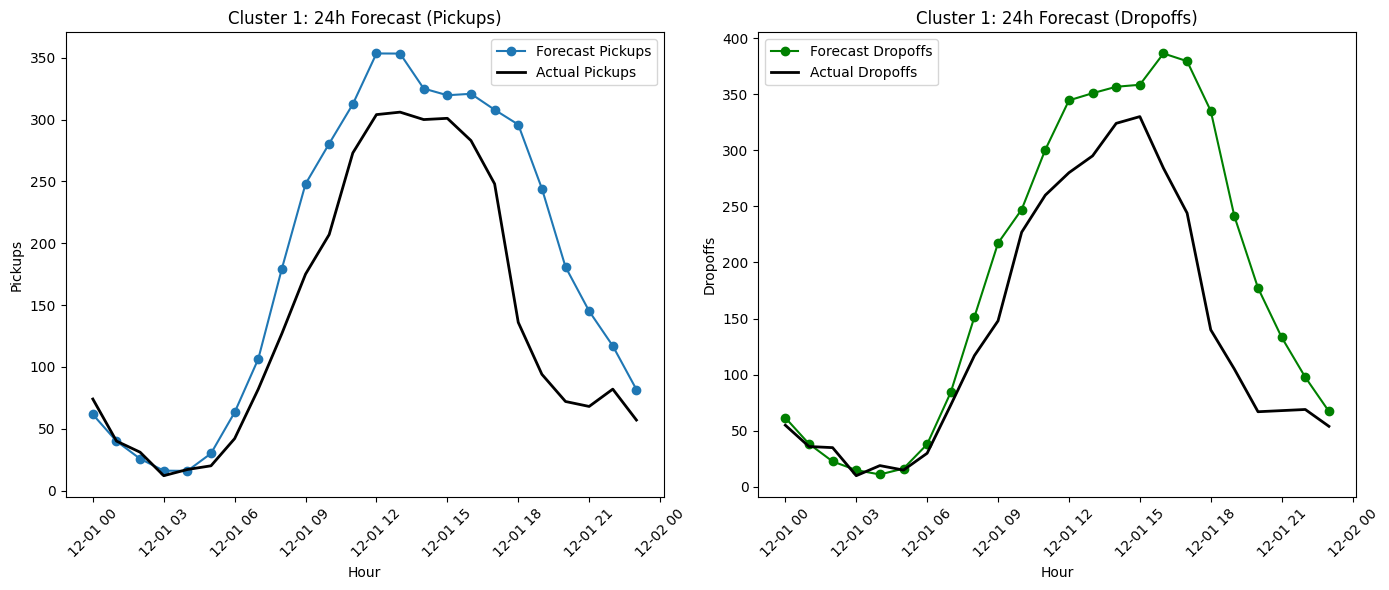

In [64]:
cluster_id  = 1
target_date = pd.to_datetime("2018-12-01").date()

actual_dec1 = test[
    (test["cluster"] == cluster_id) &
    (test["hour"].dt.date == target_date)
].copy()

forecast_dec1_weather = final_forecasts_weather[
    (final_forecasts_weather["cluster"] == cluster_id) &
    (final_forecasts_weather["forecast_hour"].dt.date == target_date)
].copy()

print("Actual rows:", len(actual_dec1), "Forecast rows (weather model):", len(forecast_dec1_weather))

plot_24h_forecast(
    cluster_id = cluster_id,
    forecast_df= forecast_dec1_weather,
    actual_df  = actual_dec1,
)


In [65]:
#no weather from the xgboost
mae_pu_no_w  = mae_pu
rmse_pu_no_w = rmse_pu
mae_do_no_w  = mae_do
rmse_do_no_w = rmse_do

#weather
mae_pu_w  = mae_pu_xgb
rmse_pu_w = rmse_pu_xgb
mae_do_w  = mae_do_xgb
rmse_do_w = rmse_do_xgb

results = pd.DataFrame({
    "Metric": ["MAE (Pickups)", "RMSE (Pickups)", "MAE (Dropoffs)", "RMSE (Dropoffs)"],
    "No Weather": [mae_pu_no_w, rmse_pu_no_w, mae_do_no_w, rmse_do_no_w],
    "With Weather": [mae_pu_w, rmse_pu_w, mae_do_w, rmse_do_w]
})

results["Improvement"] = results["No Weather"] - results["With Weather"]
results["Improvement (%)"] = 100 * results["Improvement"] / results["No Weather"]

styled = (
    results.style
        .format({
            "No Weather": "{:.3f}",
            "With Weather": "{:.3f}",
            "Improvement": "{:.3f}",
            "Improvement (%)": "{:.2f}%"
        })
        .set_caption("Comparison of XGBoost Performance With and Without Weather Features")
)

styled


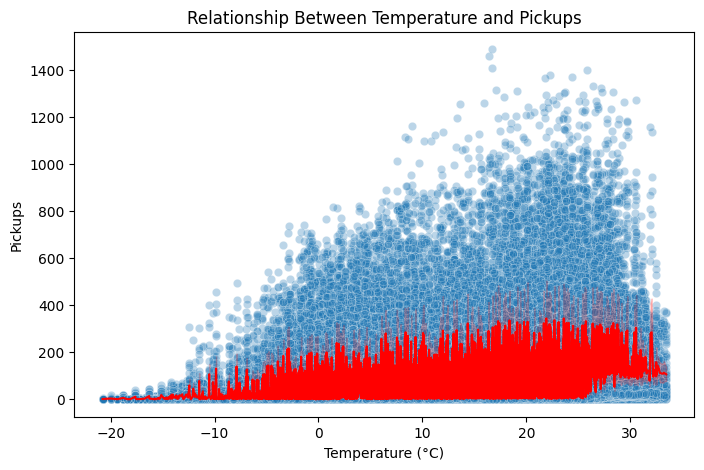

In [66]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=cluster_ts["temp_celsius"], 
    y=cluster_ts["pickups"], alpha=0.3
)
sns.lineplot(
    x=cluster_ts["temp_celsius"],
    y=cluster_ts["pickups"],
    estimator="mean",
    color="red"
)
plt.title("Relationship Between Temperature and Pickups")
plt.xlabel("Temperature (°C)")
plt.ylabel("Pickups")
plt.show()

